# Gold Price Prediction - Modeling Phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.inspection import permutation_importance

import ace_tools_open as tools;

In [2]:
# Load Data
df = pd.read_csv("../data/filtered_data.csv", index_col="Date", parse_dates=True)
df = df.ffill()
df.rename(columns={"^VIX": "VIX"}, inplace=True)
tools.display_dataframe_to_user(name="filtered data", dataframe=df)

filtered data


Loading ITables v2.4.3 from the internet... (need help?)


# Linear Regression - Case 1

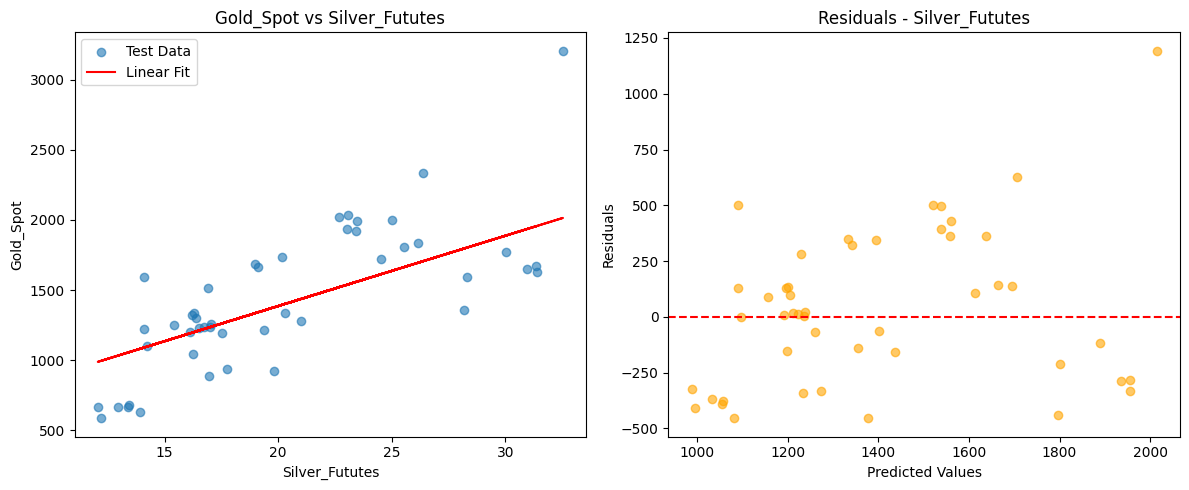

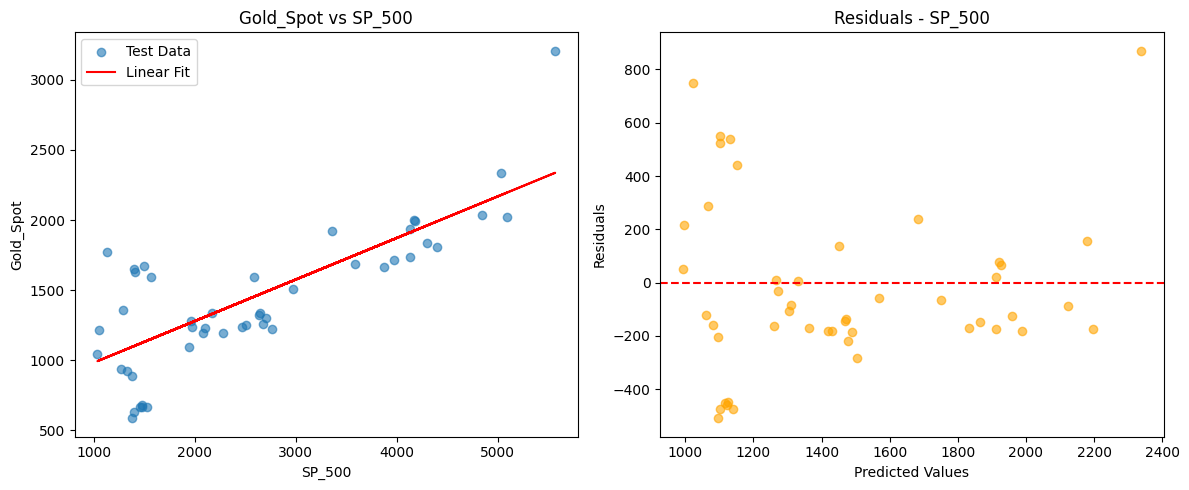

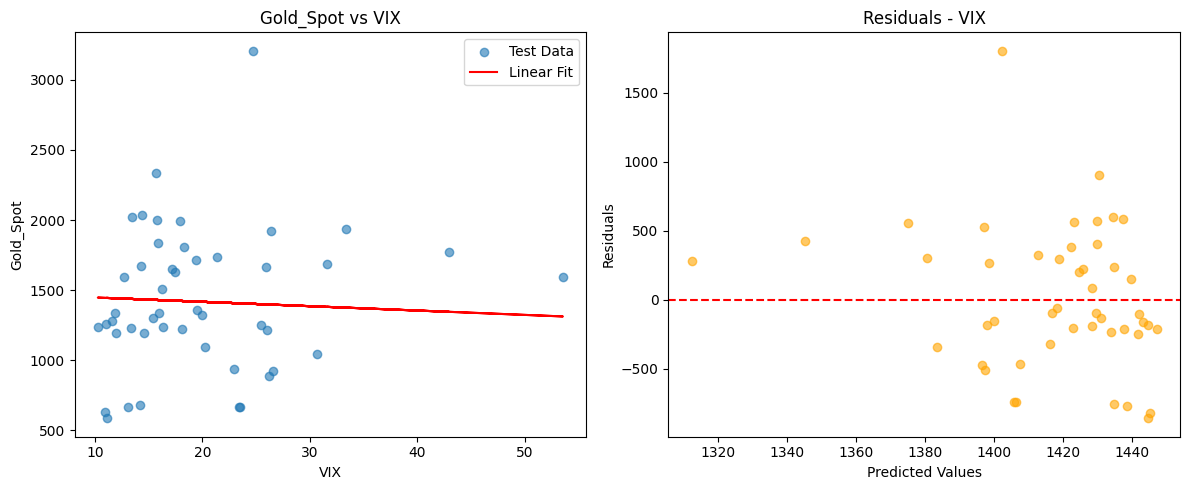

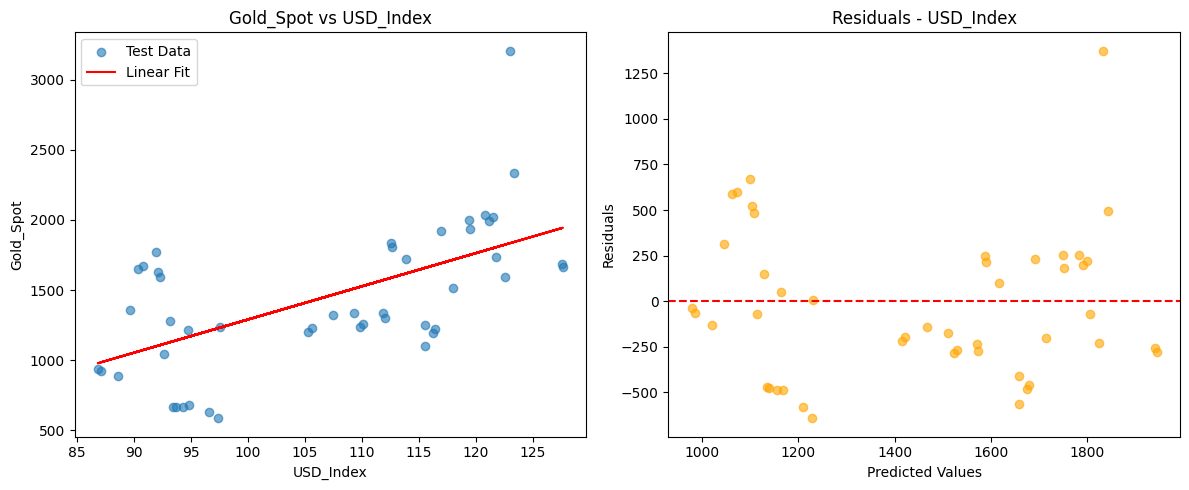

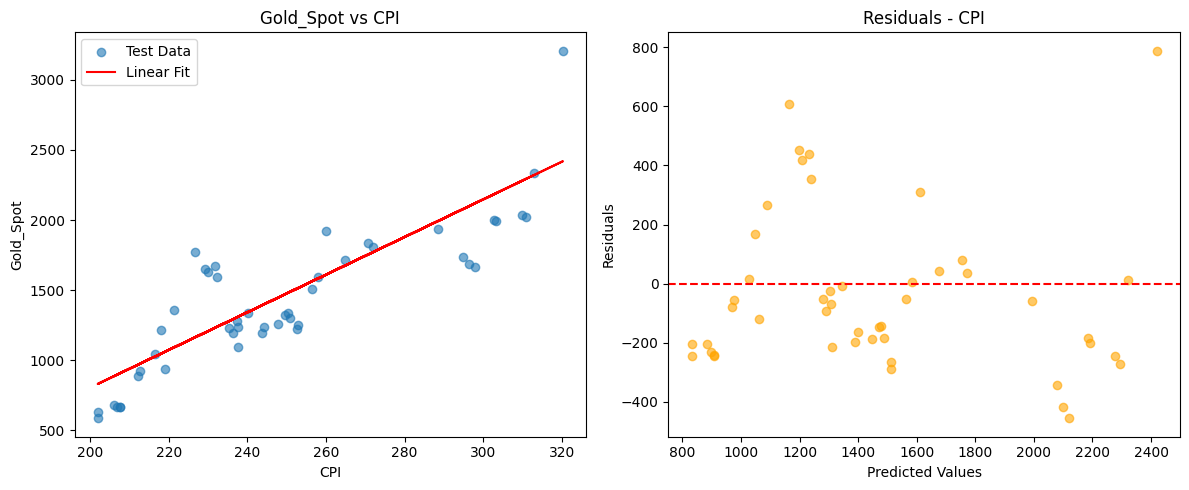

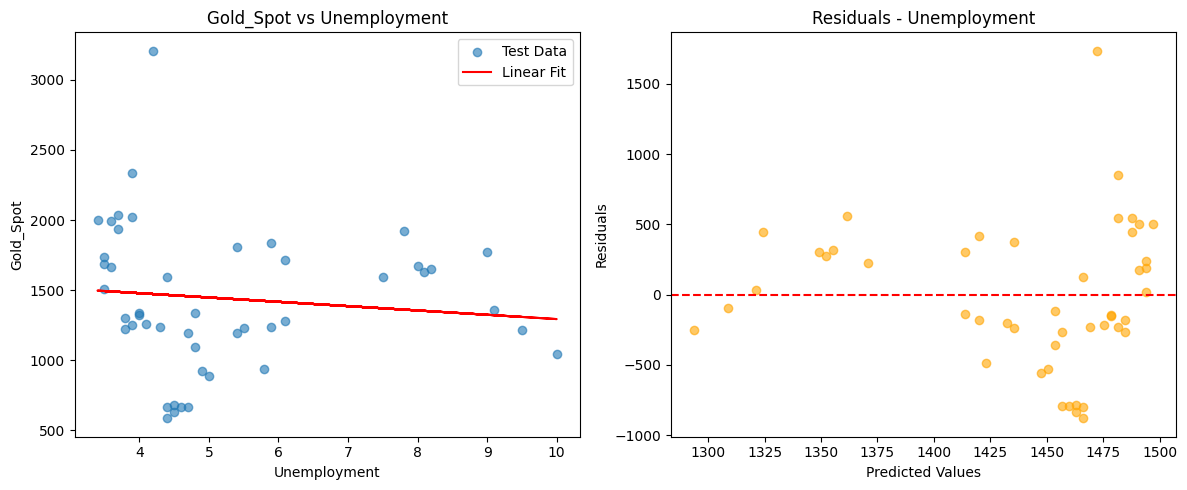

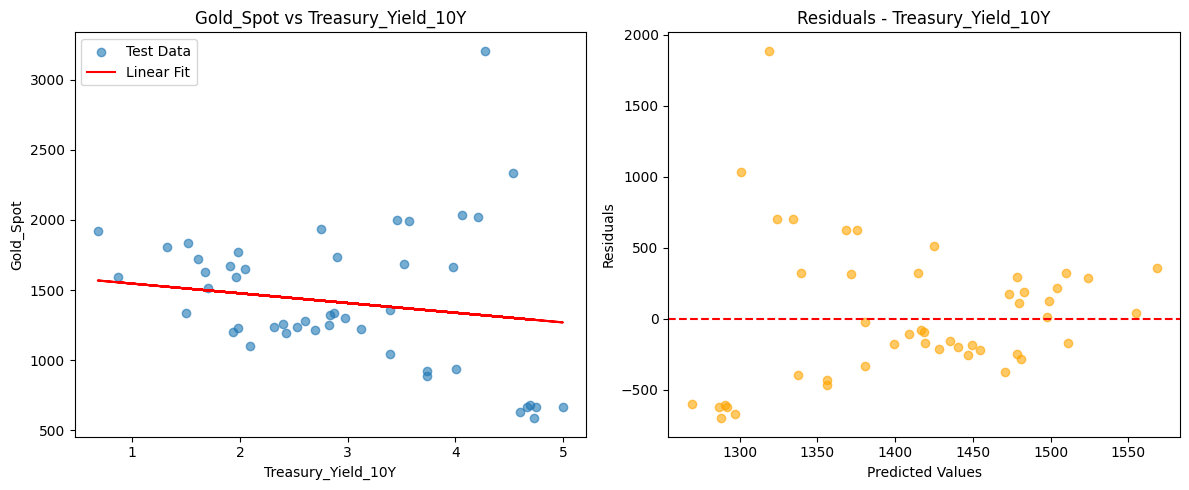

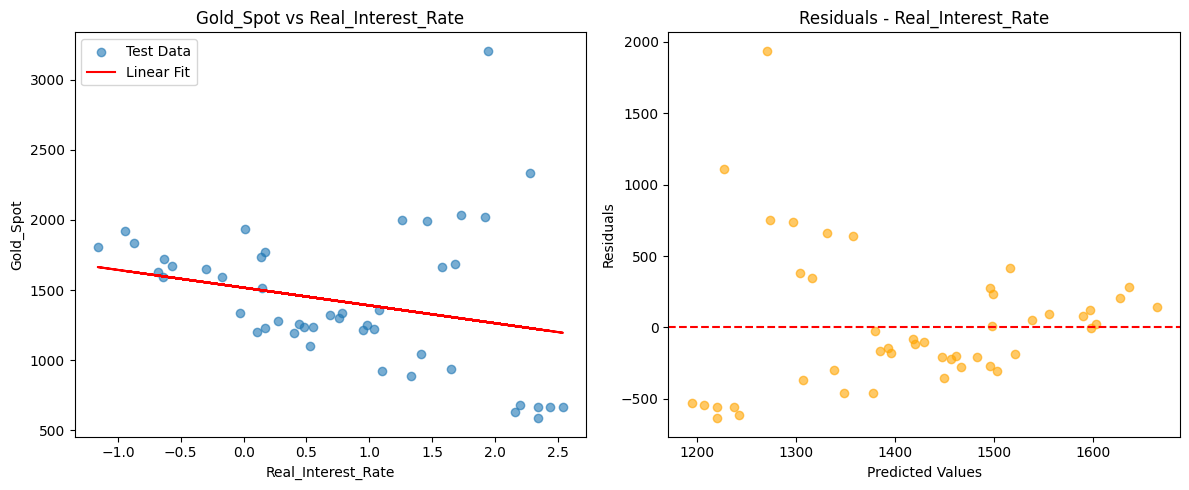

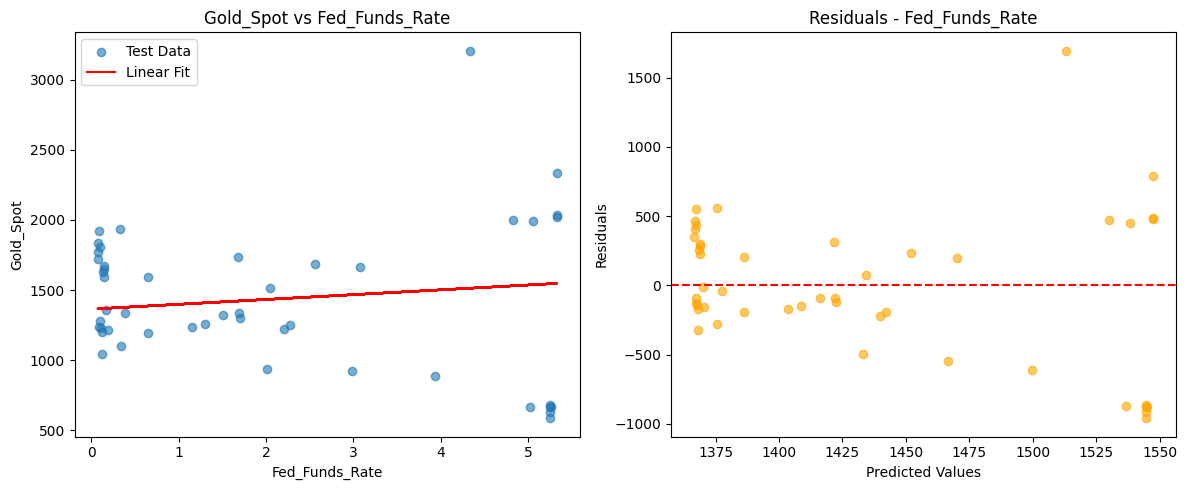

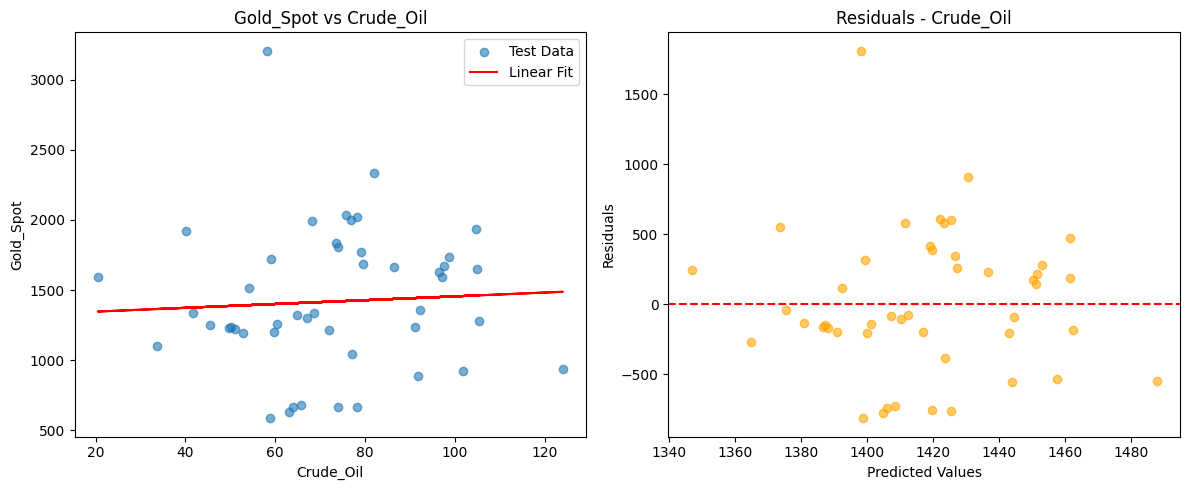

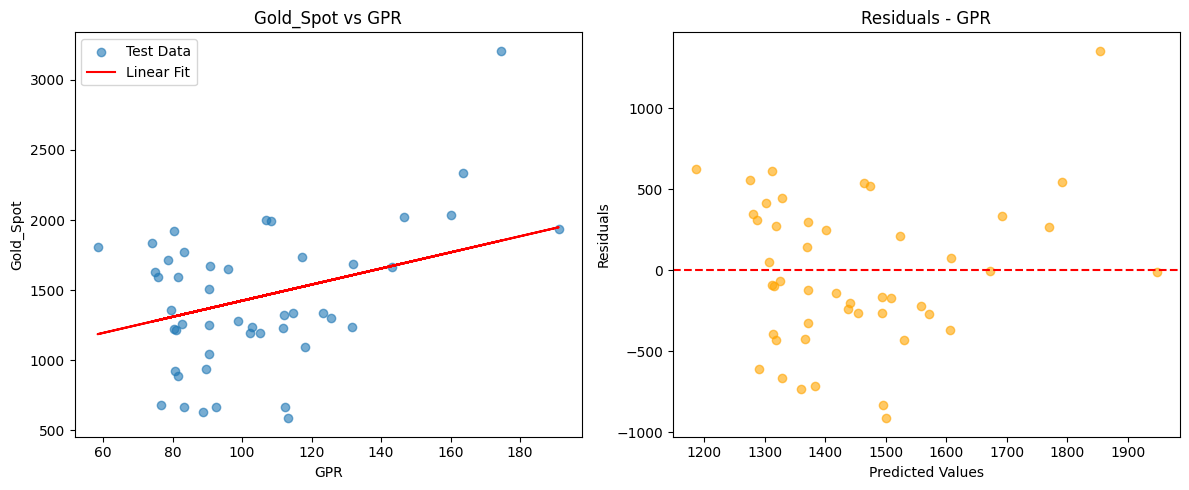

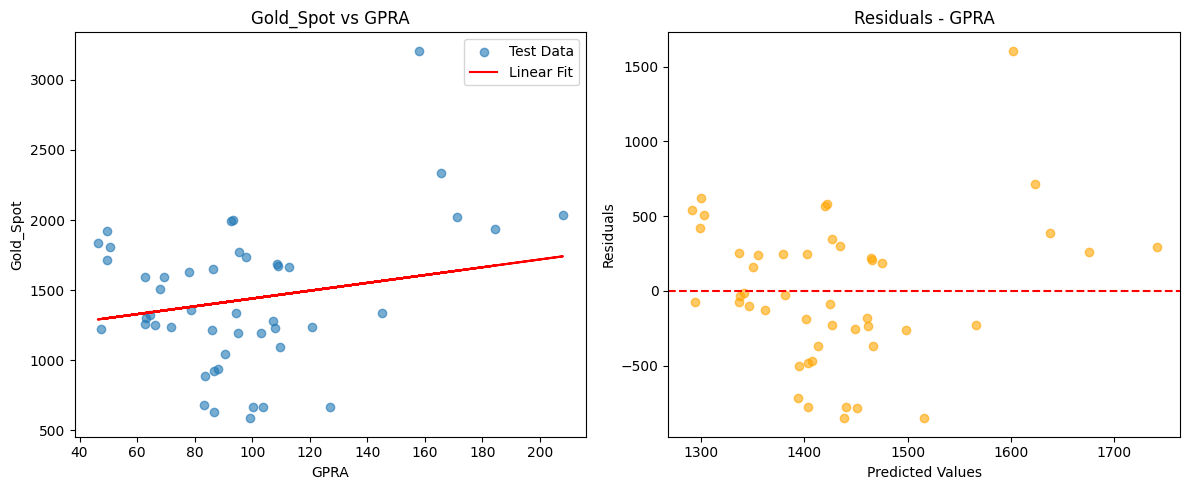


=== Summary of Case 1 (Single Variable Regression) ===


,Feature,Coefficient,Intercept,F-value,p-value,R2,MSE,RMSE,MAE
0,Silver_Fututes,50.17,382.50,253.81,4.701204e-39,0.526,120390.84,346.97,274.55
1,SP_500,0.30,686.66,463.00,4.235662e-57,0.619,96795.86,311.12,240.87
2,VIX,-3.11,1478.98,0.01,9.111517e-01,-0.020,258687.23,508.61,403.34
3,USD_Index,23.70,-1080.97,120.35,8.193987e-23,0.361,162247.26,402.80,326.55
4,CPI,13.41,-1876.60,704.66,4.109437e-72,0.720,71148.88,266.74,210.61
5,Unemployment,-30.80,1601.60,3.52,6.201715e-02,-0.002,254228.99,504.21,400.82
6,Treasury_Yield_10Y,-69.23,1615.24,7.16,7.999692e-03,0.053,240227.81,490.13,374.42
7,Real_Interest_Rate,-126.75,1517.00,16.89,5.500166e-05,0.079,233570.04,483.29,352.45
8,Fed_Funds_Rate,34.40,1364.01,1.83,1.779996e-01,-0.043,264579.73,514.37,400.19
9,Crude_Oil,1.36,1318.88,0.70,4.041658e-01,0.001,253378.34,503.37,391.79


In [3]:
# List of features to test (exclude Gold_Spot because it is the target)
features = df.columns.drop("Gold_Spot")

results = []

for feature in features:

    # --- Linear Regression (Case 1) ---
    X = df[[feature]]
    y = df["Gold_Spot"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Fit Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)

    coef = round(lin_reg.coef_[0], 2)
    intercept = round(lin_reg.intercept_, 2)

    # --- ANOVA test ---
    model_sm = smf.ols(f'Gold_Spot ~ {feature}', data=df).fit()
    anova_table = sm.stats.anova_lm(model_sm, typ=2)

    f_val = round(anova_table["F"].iloc[0], 2)
    p_val = anova_table["PR(>F)"].iloc[0]

    # R2, MSE, RMSE, MAE
    r2 = round(r2_score(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(root_mean_squared_error(y_test, y_pred), 2)
    mae = round(mean_absolute_error(y_test, y_pred), 2)

    # Save results to list
    results.append([feature, coef, intercept, f_val, p_val, r2, mse, rmse, mae])

    # Visualize
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # Scatter plot + Linear line
    axes[0].scatter(X_test, y_test, alpha=0.6, label="Test Data")
    axes[0].plot(X_test, y_pred, color='red', label="Linear Fit")
    axes[0].set_title(f"Gold_Spot vs {feature}")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Gold_Spot")
    axes[0].legend()

    # Residual plot 
    axes[1].scatter(y_pred, residuals, alpha=0.6, color="orange")
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_title(f"Residuals - {feature}")
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

# --- Summary table of results ---
summary_df = pd.DataFrame(
    results, columns=["Feature", "Coefficient", "Intercept", "F-value", "p-value", "R2", "MSE", "RMSE", "MAE"]
)

print("\n=== Summary of Case 1 (Single Variable Regression) ===")
display(summary_df)


The results indicate that not all features have a significant linear relationship with Gold_Spot.

Strong predictors: CPI (R² ≈ 0.72), S&P500 (R² ≈ 0.619), and Silver Futures (R² ≈ 0.526) show strong explanatory power with very low p-values, meaning they are statistically significant.

Moderate predictors: USD Index (R² ≈ 0.361) and GPR-related variables (R² ≈ 0.08–0.19) provide some explanatory value but weaker compared to CPI and SP500.

Weak or insignificant predictors: VIX, Crude Oil, Fed Funds Rate, and Unemployment have high p-values (≫ 0.05) and very low or even negative R², indicating they do not contribute meaningfully in a linear setting.

Overall, the best single-feature models are with CPI, SP500, and Silver Futures, which capture a large portion of gold price variation. However, most other variables individually fail to explain gold price movements well, highlighting the need for multivariate and nonlinear models.

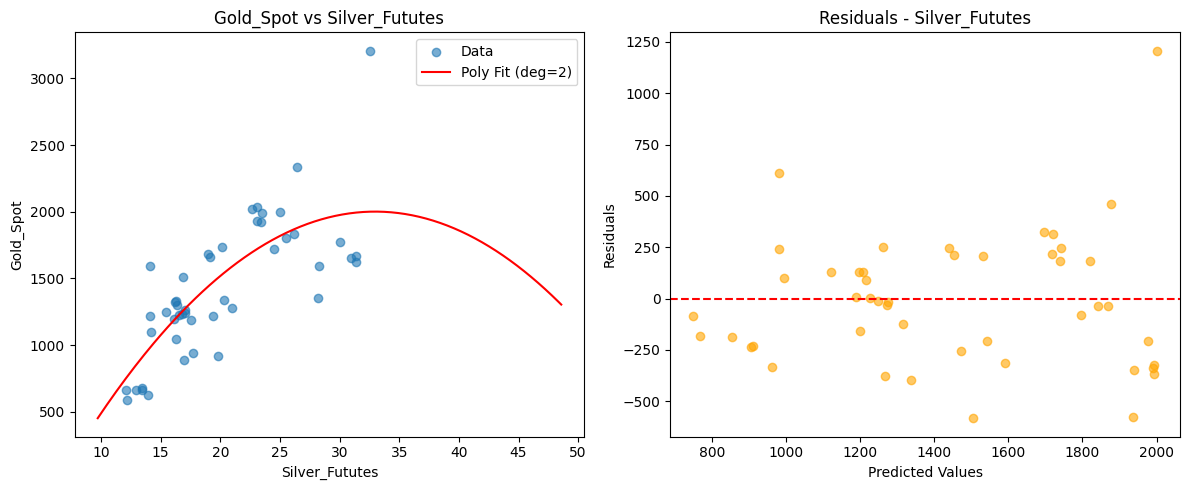

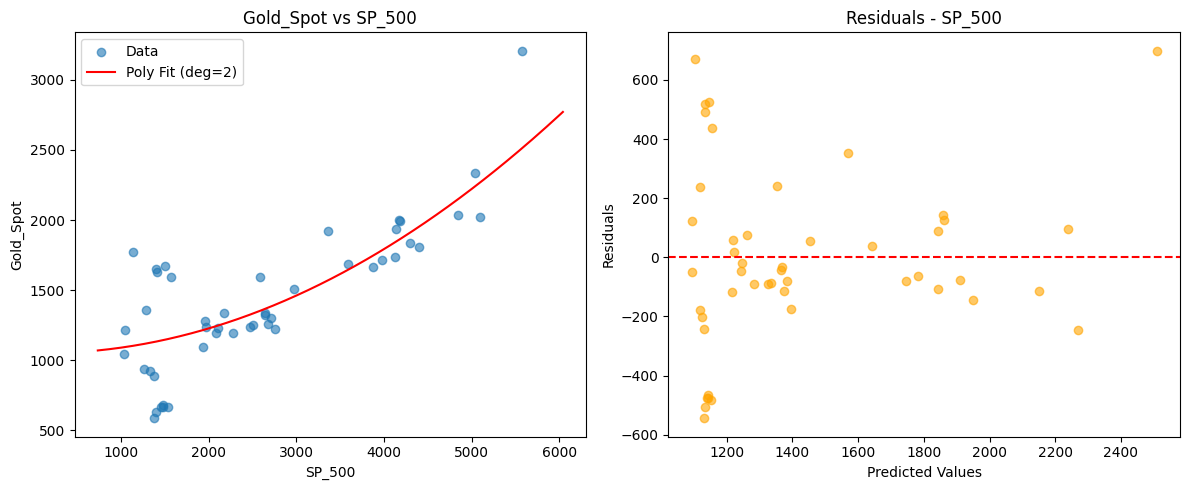

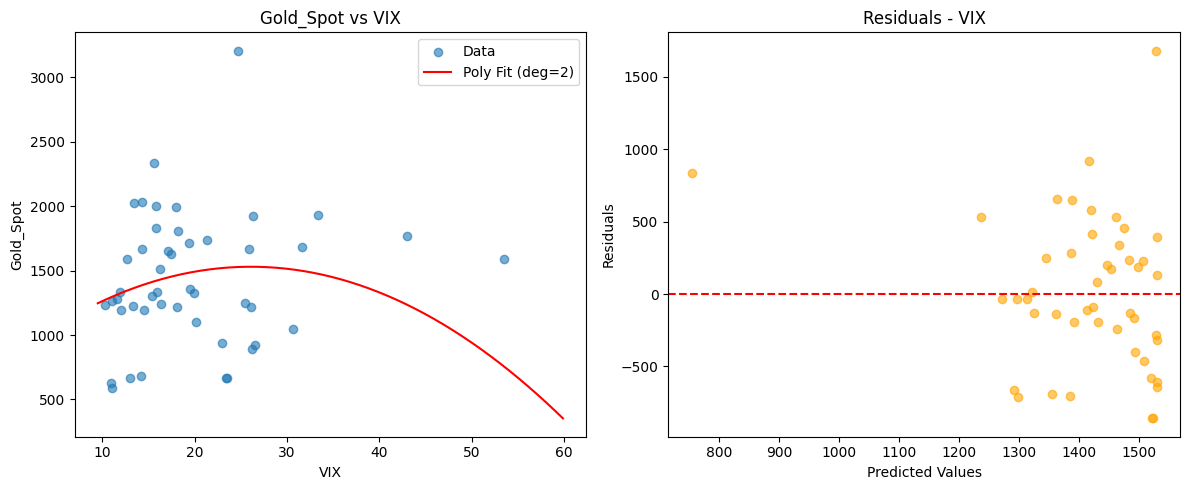

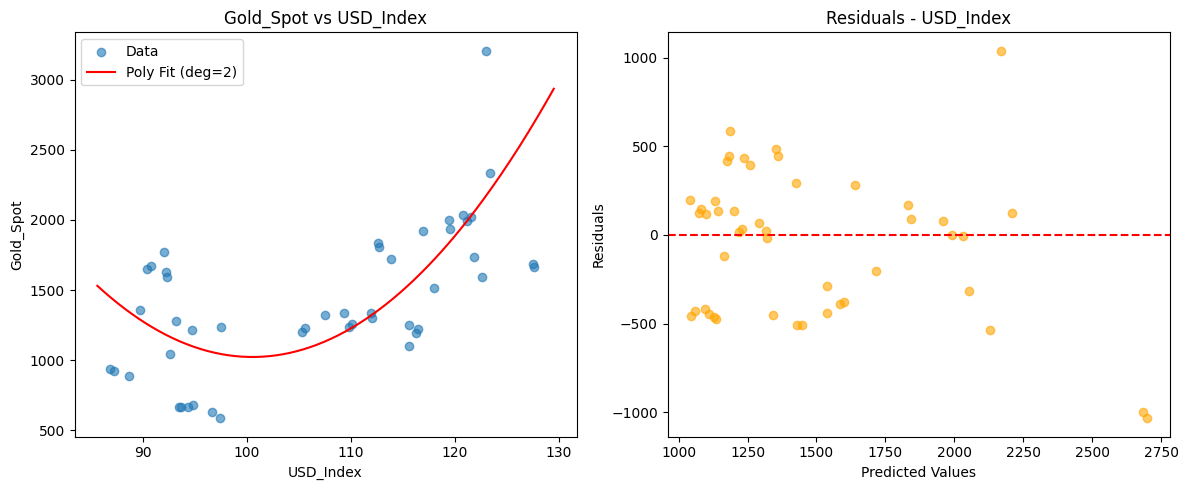

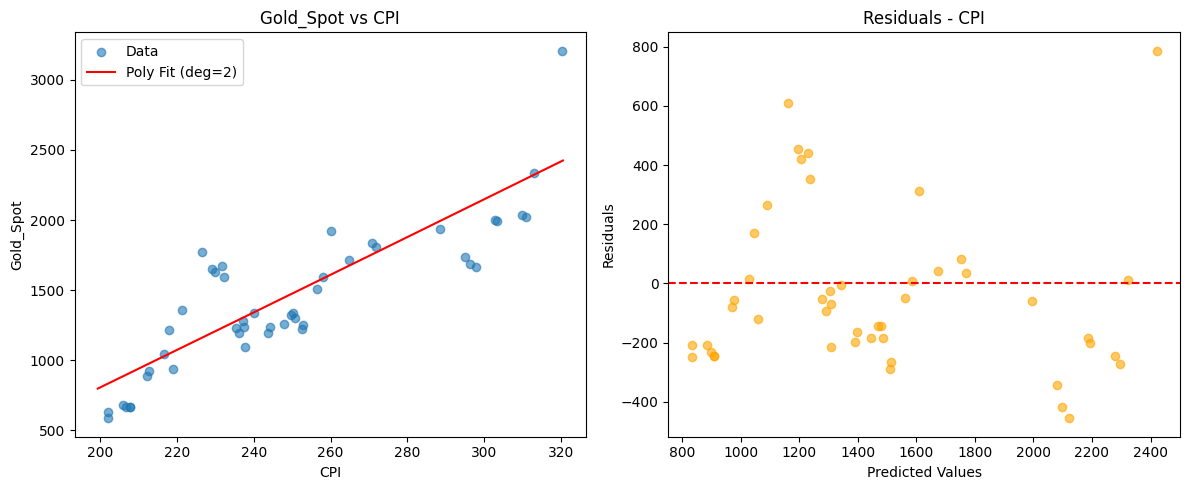

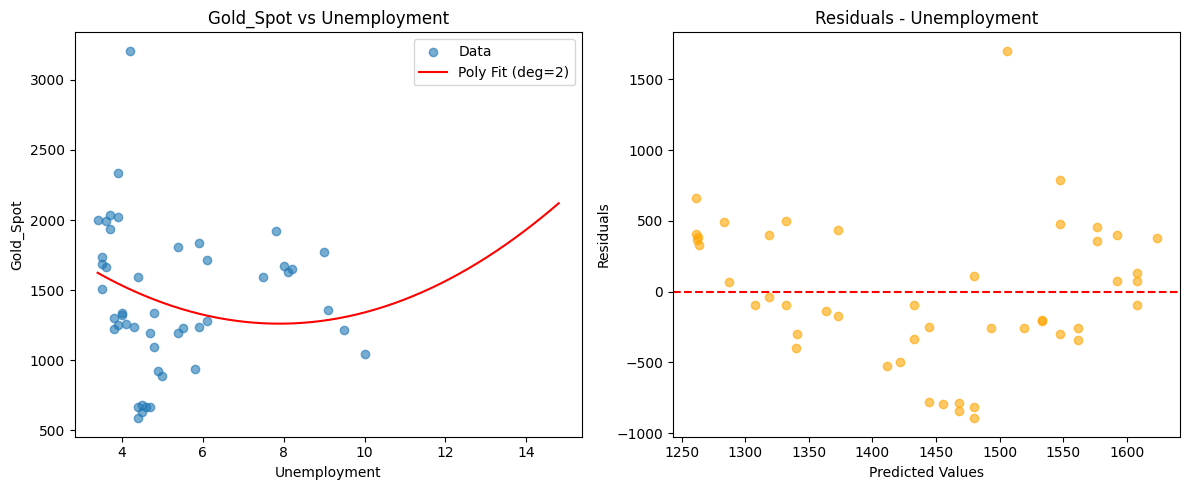

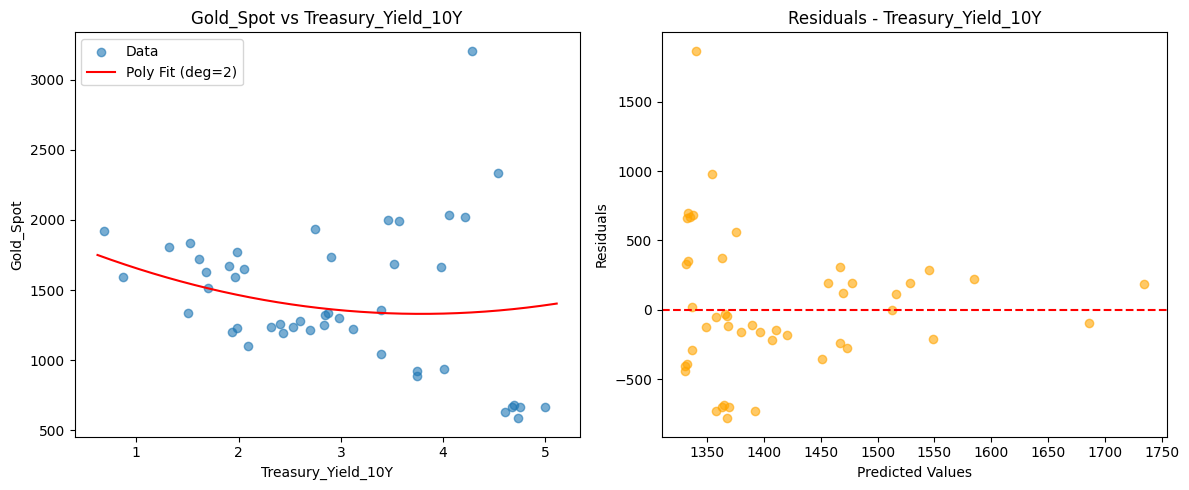

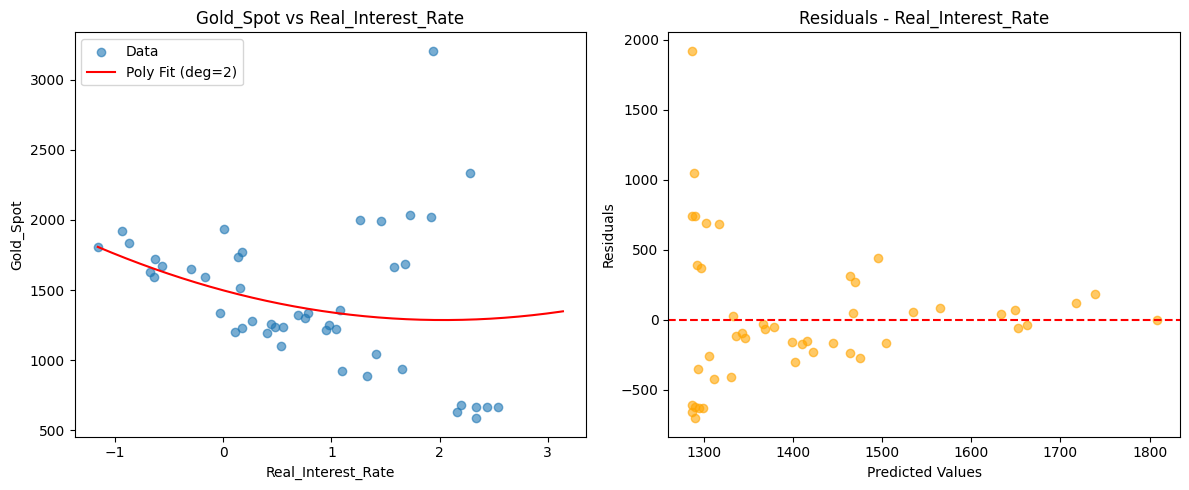

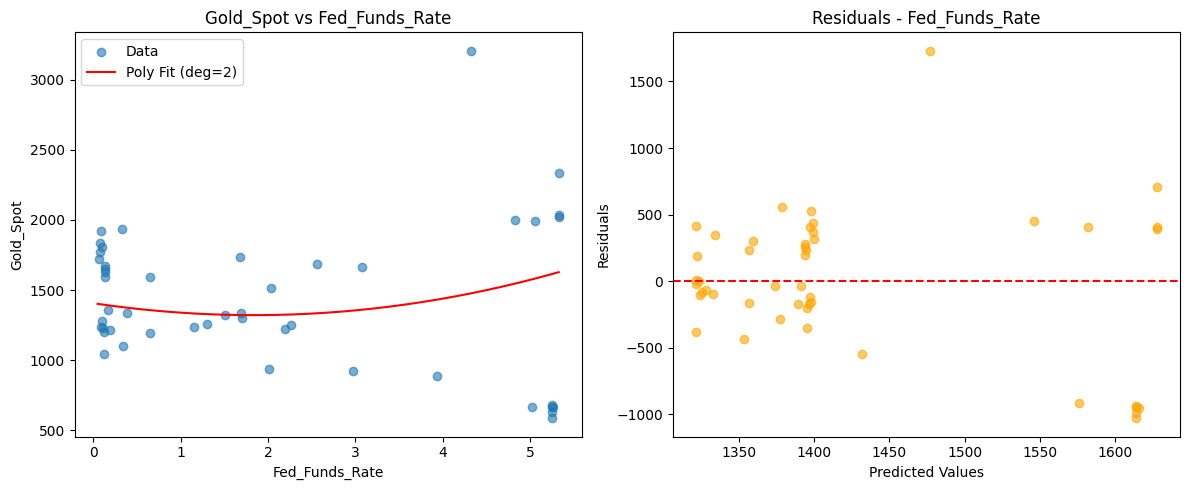

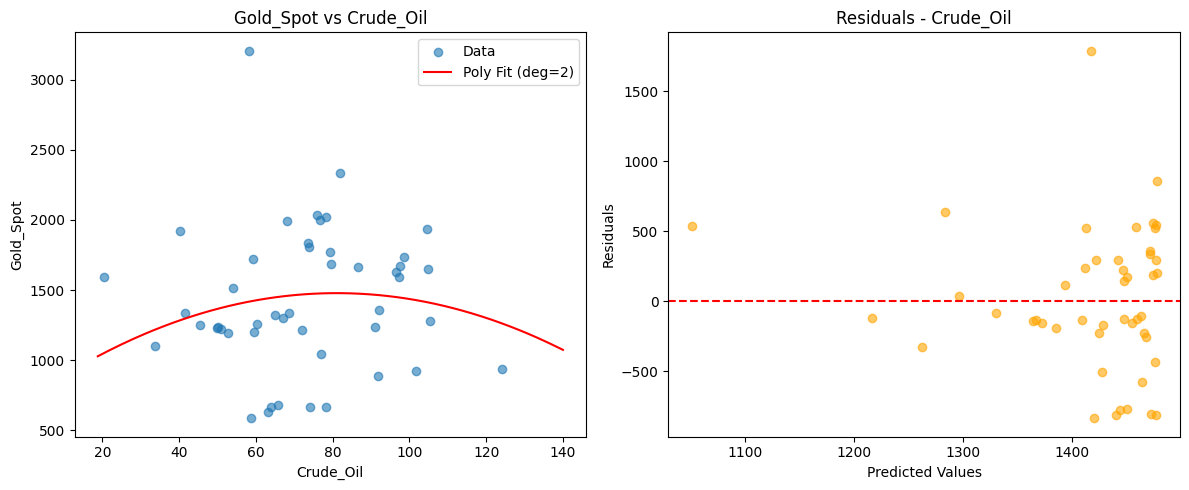

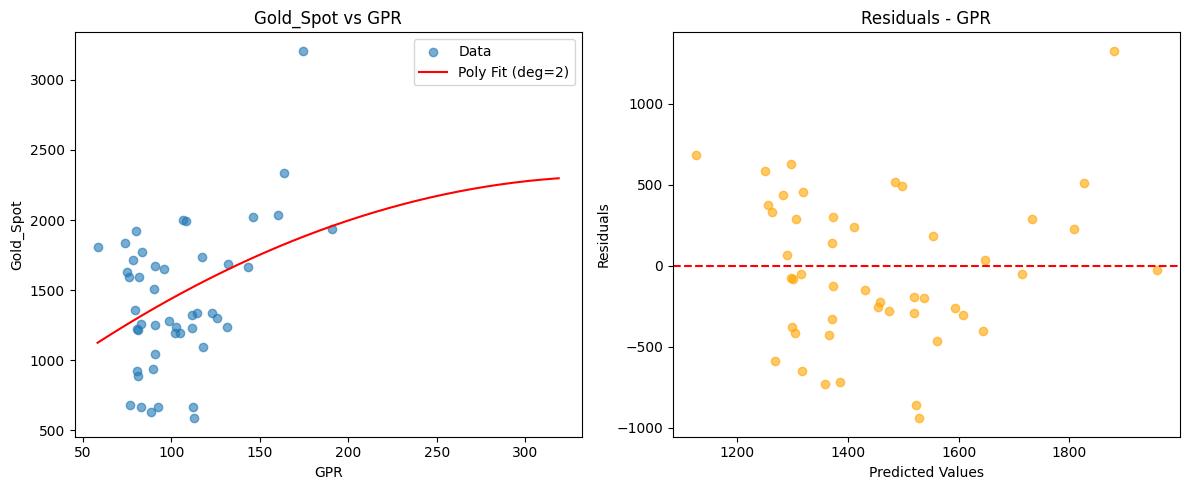

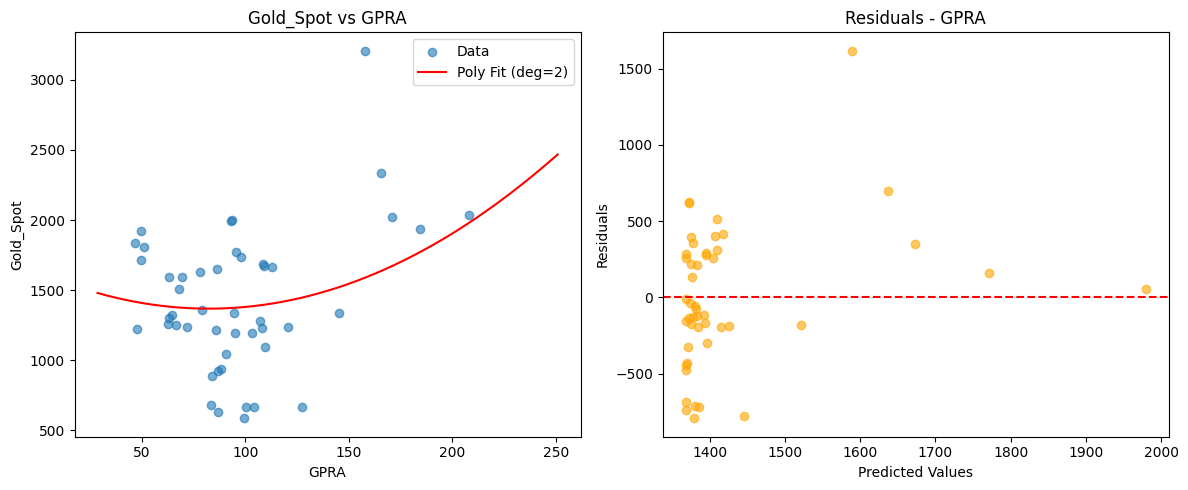


=== Summary of Polynomial Regression (degree=2, Single Variable) ===


,Feature,Coefficients,Intercept,F-value,p-value,R2,MSE,RMSE,MAE
0,Silver_Fututes,"[188.793, -2.862]",-1111.895,161.98,1.921855e-28,0.598,102030.26,319.42,244.95
1,SP_500,"[-0.009, 0.0]",1050.074,0.16,6.862689e-01,0.662,85841.37,292.99,219.91
2,VIX,"[53.778, -1.03]",828.608,9.86,1.908456e-03,-0.044,264822.73,514.61,405.22
3,USD_Index,"[-458.471, 2.28]",24065.629,104.79,1.656123e-20,0.332,169608.08,411.84,326.55
4,CPI,"[13.067, 0.001]",-1832.743,3.36,6.815812e-02,0.720,71167.93,266.77,210.67
5,Unemployment,"[-283.929, 17.991]",2381.172,11.94,6.535437e-04,0.010,251073.53,501.07,398.91
6,Treasury_Yield_10Y,"[-317.357, 41.911]",1930.921,2.69,1.023939e-01,0.027,246963.51,496.95,370.12
7,Real_Interest_Rate,"[-207.997, 51.081]",1497.850,12.52,4.881541e-04,0.076,234576.36,484.33,339.86
8,Fed_Funds_Rate,"[-92.599, 25.164]",1406.218,0.98,3.221852e-01,-0.060,268950.23,518.60,390.44
9,Crude_Oil,"[18.873, -0.116]",713.231,3.44,6.476114e-02,-0.004,254799.38,504.78,391.58


In [4]:
# Polynomial Regression
df.rename(columns={"S&P_500": "SP500", "^VIX": "VIX"}, inplace=True)
features = df.columns.drop("Gold_Spot")

results_poly = []

for feature in features:
    X = df[[feature]]
    y = df["Gold_Spot"]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Polynomial transform (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    coefs = [round(c, 3) for c in model.coef_]
    intercept = round(model.intercept_, 3)

    # ANOVA test
    formula = f"Gold_Spot ~ {feature} + I({feature}**2)"
    model_sm = smf.ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model_sm, typ=2)

    f_val = round(anova_table["F"].iloc[0], 2)
    p_val = anova_table["PR(>F)"].iloc[0]

    # Metris
    r2 = round(r2_score(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(root_mean_squared_error(y_test, y_pred), 2)
    mae = round(mean_absolute_error(y_test, y_pred), 2)

    results_poly.append([feature, coefs, intercept, f_val, p_val, r2, mse, rmse, mae])

    # Visualization
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter + Poly Fit
    X_sorted = pd.DataFrame(
        np.linspace(X[feature].min(), X[feature].max(), 200), 
        columns=[feature]
    )
    X_sorted_poly = poly.transform(X_sorted)
    
    y_sorted_pred = model.predict(X_sorted_poly)

    axes[0].scatter(X_test, y_test, alpha=0.6, label="Data")
    axes[0].plot(X_sorted, y_sorted_pred, color="red", label="Poly Fit (deg=2)")
    axes[0].set_title(f"Gold_Spot vs {feature}")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Gold_Spot")
    axes[0].legend()

    # Residual plot
    axes[1].scatter(y_pred, residuals, alpha=0.6, color="orange")
    axes[1].axhline(0, color="red", linestyle="--")
    axes[1].set_title(f"Residuals - {feature}")
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

# --- Summary table ---
summary_poly = pd.DataFrame(
    results_poly,
    columns=["Feature", "Coefficients", "Intercept", "F-value", "p-value", "R2", "MSE", "RMSE", "MAE"]
)

print("\n=== Summary of Polynomial Regression (degree=2, Single Variable) ===")
display(summary_poly)

The polynomial models show mixed performance across features.

Best predictors: CPI (R² ≈ 0.72), SP500 (R² ≈ 0.66), and Silver Futures (R² ≈ 0.60) remain the strongest variables, similar to linear regression, with improved fit in some cases.

Moderate predictors: USD Index (R² ≈ 0.33) and GPR-related indices (R² ≈ 0.17–0.18) capture partial variations but are less reliable.

Weak/insignificant predictors: VIX, Crude Oil, Fed Funds Rate, and Unemployment show very low or even negative R² values, meaning polynomial transformation does not improve their predictive power.

Overall, polynomial regression slightly enhances performance for Silver Futures but does not drastically outperform linear models. Strong explanatory features remain consistent, suggesting that multivariate approaches are more promising.

# Linear Regression - Case 2(Multi-Variables)

In [5]:
# =======================================
# 1. Define features and target
# =======================================

X = df.drop(columns=["Gold_Spot"])
y = df["Gold_Spot"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# =======================================
# 2. Sklearn Model (Prediction metrics)
# =======================================
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

r2 = round(r2_score(y_test, y_pred), 3)
adj_r2 = round(1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1), 3)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(root_mean_squared_error(y_test, y_pred), 2)
mae = round(mean_absolute_error(y_test, y_pred), 2)

print("\n=== Multi-variable Linear Regression Results ===")
print("Intercept:", round(lin_reg.intercept_, 2))
print("R2:", r2, " | Adjusted R2:", adj_r2)
print("MSE:", mse, " | RMSE:", rmse, " | MAE:", mae)


=== Multi-variable Linear Regression Results ===
Intercept: -1009.58
R2: 0.947  | Adjusted R2: 0.928
MSE: 13427.07  | RMSE: 115.88  | MAE: 77.06


In [7]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lin_reg.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n=== Coefficients (Sklearn) ===")
display(coef_df)



=== Coefficients (Sklearn) ===


,Feature,Coefficient
5,Unemployment,32.040555
0,Silver_Fututes,25.494192
7,Real_Interest_Rate,24.052517
4,CPI,10.203313
8,Fed_Funds_Rate,5.124334
2,VIX,1.506219
10,GPR,0.224605
1,SP_500,0.103026
11,GPRA,0.077564
9,Crude_Oil,-2.202604


In [8]:
# =======================================
# 3. Statsmodels OLS (ANOVA & p-value) 
# =======================================

# Combine features and target into one DataFrame for formula API
train_df = X_train.copy()
train_df["Gold_Spot"] = y_train

# Create the regression formula
formula = "Gold_Spot ~ " + " + ".join(X_train.columns)

# Fit the OLS model using formula API
ols_model = smf.ols(formula=formula, data=train_df).fit()

# Print summary
print("\n=== OLS Summary ===")
display(ols_model.summary())

# ANOVA table
anova_results = anova_lm(ols_model, typ=2)
print("\n=== ANOVA Table ===")
display(anova_results)


=== OLS Summary ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gold_Spot   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     312.9
Date:                Wed, 29 Oct 2025   Prob (F-statistic):          1.89e-110
Time:                        14:37:21   Log-Likelihood:                -1128.9
No. Observations:                 186   AIC:                             2284.
Df Residuals:                     173   BIC:                             2326.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1009.5804    276.005     -3.658      0.000   -1554.350    -464.810
Silver_Fututes        25.4942      2.101     12.137      0.000      21.348      29.640
SP_500                 0.1030      0.027      3.867      0.000       0.050       0.156
VIX                    1.5062      1.274      1.183      0.239      -1.008       4.020
USD_Index             -7.8382      3.001     -2.611      0.010     -13.762      -1.914
CPI                   10.2033      1.391      7.335      0.000       7.458      12.949
Unemployment          32.0406      6.286      5.097      0.000      19.633      44.449
Treasury_Yield_10Y   -52.3773     38.125     -1.374      0.171    -127.627      22.872
Real_Interest_Rate    24.0525     37.798      0.636      0.525     -50.551      98.656
Fed_Funds_Rate         5.1243     10.001      0.512      0.609     -14.616      24.865
Crude_Oil             -2.2026      0.950     -2.318      0.022      -4.078      -0.327
GPR                    0.2246      0.547      0.410      0.682      -0.856       1.305
GPRA                   0.0776      0.463      0.168      0.867      -0.836       0.991
==============================================================================
Omnibus:                       59.006   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              449.028
Skew:                           0.928   Prob(JB):                     3.12e-98
Kurtosis:                      10.382   Cond. No.                     9.90e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


=== ANOVA Table ===


,sum_sq,df,F,PR(>F)
Silver_Fututes,1.733689e+06,1.0,147.304108,6.425788e-25
SP_500,1.759958e+05,1.0,14.953605,1.557647e-04
VIX,1.646039e+04,1.0,1.398569,2.385861e-01
USD_Index,8.026645e+04,1.0,6.819895,9.806788e-03
CPI,6.331877e+05,1.0,53.799242,8.223651e-12
Unemployment,3.057372e+05,1.0,25.977175,8.988708e-07
Treasury_Yield_10Y,2.221412e+04,1.0,1.887439,1.712686e-01
Real_Interest_Rate,4.765955e+03,1.0,0.404943,5.253886e-01
Fed_Funds_Rate,3.089647e+03,1.0,0.262514,6.090517e-01
Crude_Oil,6.324569e+04,1.0,5.373715,2.161253e-02


**Importance Features (p < 0.05, CI not include 0)**
- Silver_Futures (β = 25.49, p = 0.000) -> Very strong, positive
- SP_500 (β = 0.103, p = 0.000) -> Positive
- USD_Index (β = -7.838, p = 0.010) -> Positive, suit theory
- CPI (β = 10.20, p = 0.000) -> Positve
- Unemployment (β = 32.04, p = 0.000) -> Positive, Unemployment rate inscrease -> Gold Price Increse (Safe haven assets)
- Crude_Oil (β = -2.20, p = 0.022) -> Negative, weird -> Oil price increse -> CPI increse so Gold Price should also be incease --> Could be because multicollinearity.

**Not so Importance Features(p > 0.05, CI include 0)**:
- VIX (p = 0.239) -> unclear relationship
- Treasury_Yield_10Y (p = 0.171) -> the highest coef (absolute value) but p > 0.05 -> Check multicollinearity
- Real_Interest_Rate (p = 0.525) -> Not statistically significant
- Fed_Funds_Rate (p = 0.609) -> Not statistically significant
- GPR, GPRA (p = 0.682, 0.867) -> Not statistically significant


**Key metrics to focus**
- Overall fit: R2, Adj R2, F-statistic.
- Significance of predictors: p-values(OLS, ANOVA).
- Durbin-Watson(2.221): Near 2, there is no major problem with residual autocorrelation.
- Omnibus/ JB test: Prob = 0.0000: The residuals are not normally distributed (Skew > 0, Kurtosis > 10). → This affects the reliability of the t and F tests.
- Condition Number = 9.90e+04 (very high) -> high percentage of multicollinearity between features(Featues have strict relationship with eachother like Crude Oil, interest rate, Stock Index)
- Potential issues: Condition number (multicollinearity), Residual diagnostics(normality, homoscedasticity).

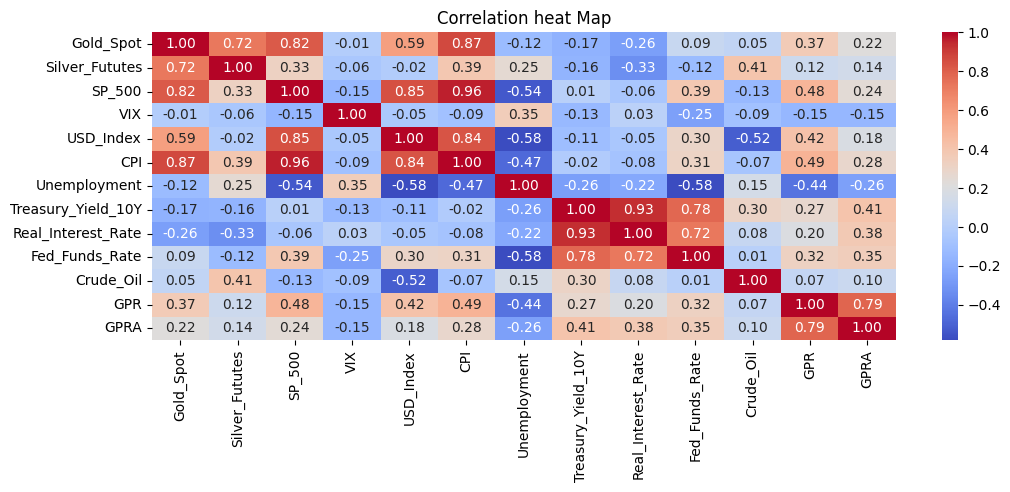

In [9]:
corr_matrix = df.corr()

plt.figure(figsize=(12,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation heat Map")
plt.show()

**Heat Map**
+ High collinearity
    - USD_Index - CPI (0.96)
    - Treasury_Yield_10Y - Real_Interest_Rate (0.93)
    - SP_500 - USD_Index (0.85)
    - GPR - GPRA (0.79)
    - Silver_Futures - SP_500 (0.72)

In [10]:
# =======================================
# VIF (Check Multicollinearity)
# =======================================
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]
print("\n=== VIF (Check Multicollinearity) ===")
display(vif_data.sort_values(by="VIF", ascending=True))


=== VIF (Check Multicollinearity) ===


,Feature,VIF
8,Fed_Funds_Rate,9.870686
2,VIX,11.449269
5,Unemployment,23.609010
7,Real_Interest_Rate,30.805105
11,GPRA,32.716100
0,Silver_Fututes,33.209658
1,SP_500,48.054384
10,GPR,50.156879
9,Crude_Oil,76.452085
6,Treasury_Yield_10Y,179.921801


In [11]:
# =======================================
# Drop non-significant predictor
# =======================================
X_dr = df.drop(columns=["Gold_Spot","VIX", "Treasury_Yield_10Y", "Real_Interest_Rate", "Fed_Funds_Rate", "GPR", "GPRA"])
y_dr = df["Gold_Spot"]

X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, test_size=0.2, random_state=42)

lin_reg_dr = LinearRegression()
lin_reg_dr.fit(X_train_dr, y_train_dr)
y_pred_dr = lin_reg_dr.predict(X_test_dr)

r2 = round(r2_score(y_test_dr, y_pred_dr), 3)
n, p = X_test_dr.shape
adj_r2 = round(1 - (1-r2) * (n-1) / (n-p-1), 3)
mse = round(mean_squared_error(y_test_dr, y_pred_dr), 2)
rmse = round(root_mean_squared_error(y_test_dr, y_pred_dr), 2)
mae = round(mean_absolute_error(y_test_dr, y_pred_dr), 2)

print("\n=== Reduced Linear Regression Results ===")
print("Intercept:", round(lin_reg_dr.intercept_, 2))
print("R2:", r2, " | Adjusted R2:", adj_r2)
print("MSE:", mse, " | RMSE:", rmse, " | MAE:", mae)

# =======================================
# Statsmodels OLS (ANOVA & p-value) 
# =======================================

# Combine features and target into one DataFrame for formula API
train_df = X_train_dr.copy()
train_df["Gold_Spot"] = y_train_dr

# Create the regression formula
formula = "Gold_Spot ~ " + " + ".join(X_train_dr.columns)

# Fit the OLS model using formula API
ols_model = smf.ols(formula=formula, data=train_df).fit()

# Print summary
print("\n=== OLS Summary ===")
display(ols_model.summary())

# ANOVA table
anova_results = anova_lm(ols_model, typ=2)
print("\n=== ANOVA Table ===")
display(anova_results)


=== Reduced Linear Regression Results ===
Intercept: -1261.38
R2: 0.94  | Adjusted R2: 0.931
MSE: 15268.82  | RMSE: 123.57  | MAE: 88.01

=== OLS Summary ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gold_Spot   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     610.4
Date:                Wed, 29 Oct 2025   Prob (F-statistic):          2.47e-116
Time:                        14:37:21   Log-Likelihood:                -1134.1
No. Observations:                 186   AIC:                             2282.
Df Residuals:                     179   BIC:                             2305.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1261.3762    248.296     -5.080      0.000   -1751.341    -771.412
Silver_Fututes    25.9575      1.853     14.007      0.000      22.301      29.614
SP_500             0.0847      0.023      3.663      0.000       0.039       0.130
USD_Index         -7.1080      2.987     -2.379      0.018     -13.003      -1.213
CPI               10.9254      1.279      8.545      0.000       8.402      13.449
Unemployment      36.1232      5.263      6.864      0.000      25.739      46.508
Crude_Oil         -2.9563      0.811     -3.645      0.000      -4.557      -1.356
==============================================================================
Omnibus:                       39.545   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.811
Skew:                           0.508   Prob(JB):                     5.75e-60
Kurtosis:                       8.845   Cond. No.                     8.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


=== ANOVA Table ===


,sum_sq,df,F,PR(>F)
Silver_Fututes,2.361329e+06,1.0,196.203383,1.402805e-30
SP_500,1.614466e+05,1.0,13.414632,3.286017e-04
USD_Index,6.813662e+04,1.0,5.661488,1.839334e-02
CPI,8.786764e+05,1.0,73.009423,5.517882e-15
Unemployment,5.670595e+05,1.0,47.117101,1.057561e-10
Crude_Oil,1.598764e+05,1.0,13.284171,3.505667e-04
Residual,2.154285e+06,179.0,NaN,NaN


In [12]:
# =======================================
# VIF after drop non-significant features
# =======================================
vif_data_dr = pd.DataFrame()
vif_data_dr["Feature"] = X_train_dr.columns
vif_data_dr["VIF"] = [variance_inflation_factor(X_train_dr.values, i)
                   for i in range(X_train_dr.shape[1])]
print("\n=== VIF (Check Multicollinearity) ===")
display(vif_data_dr.sort_values(by="VIF", ascending=True))


=== VIF (Check Multicollinearity) ===


,Feature,VIF
4,Unemployment,16.092839
0,Silver_Fututes,24.488287
5,Crude_Oil,36.690862
1,SP_500,39.663427
2,USD_Index,787.355462
3,CPI,1549.222998


**Comment**
- Remove non-significant features or important feartures will reduce VIF but not as expected, Multicollinearity often occurs in macroeconomic and financial datasets due to the economic nature -> Remove fearutes does not solved multicollinearity

## Compare After Drop non-significant predictors
### Comparison of OLS Regression Results (Before vs After Variable Selection)

| Metric                | Full Model (Before) | Reduced Model (After) | Interpretation |
|------------------------|---------------------|------------------------|----------------|
| **R²**                | 0.956              | 0.953                 | Slightly lower, but almost the same → model still explains ~95% variance. |
| **Adjusted R²**       | 0.953              | 0.952                 | Almost unchanged → reduced model keeps explanatory power with fewer predictors. |
| **F-statistic**       | 312.9              | 610.4                 | Higher in reduced model → overall model fit per degree of freedom improved. |
| **Prob (F-statistic)**| 1.89e-110          | 2.47e-116             | Both ≈ 0 → both models highly significant. |
| **AIC**               | 2284               | 2282                  | Lower in reduced model → better trade-off between fit & complexity. |
| **BIC**               | 2326               | 2305                  | Lower in reduced model → simpler and better. |
| **# Predictors (Df Model)** | 12          | 6                      | Reduced model is more parsimonious (fewer predictors). |
| **Residual df**       | 173                | 179                   | Slightly higher in reduced model, since fewer predictors. |
| **Omnibus Prob**      | 0.000              | 0.000                 | Both show residuals not perfectly normal. |
| **Skew**              | 0.928              | 0.508                 | Improved (residuals closer to normal). |
| **Kurtosis**          | 10.38              | 8.85                  | Still high, but improved → reduced model has better residual distribution. |
| **Condition No.**     | 9.90e+04           | 8.77e+04              | Slightly lower → reduced multicollinearity risk. |



## Ridge

In [13]:
from sklearn.linear_model import Ridge

# =======================================
# Ridge Regression
# =======================================

ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
y_predict_ridge = ridge.predict(X_test)

# Metrics
r2 = round(r2_score(y_test, y_pred), 3)
n, p = X_test.shape
adj_r2 = round(1 - (1-r2) * (n-1) / (n-p-1), 3)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(root_mean_squared_error(y_test, y_pred), 2)
mae = round(mean_absolute_error(y_test, y_pred), 2)

print("\n=== Ridge Regression Results ===")
print("Intercept:", round(ridge.intercept_, 2))
print("R2:", r2, " | Adjusted R2:", adj_r2)
print("MSE:", mse, " | RMSE:", rmse, " | MAE:", mae)


=== Ridge Regression Results ===
Intercept: -1053.56
R2: 0.947  | Adjusted R2: 0.928
MSE: 13427.07  | RMSE: 115.88  | MAE: 77.06


In [14]:
from sklearn.model_selection import GridSearchCV

rigde = Ridge()
params = {"alpha":[0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(ridge, params, cv=5, scoring="r2")
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best CV R2:", grid.best_score_)

Best alpha: {'alpha': 100}
Best CV R2: 0.9470176962113432


In [15]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": ridge.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n=== Coefficients Rigde ===")
display(coef_df)


=== Coefficients Rigde ===


,Feature,Coefficient
0,Silver_Fututes,25.787782
5,Unemployment,24.392660
4,CPI,10.725661
2,VIX,2.223337
1,SP_500,0.093044
10,GPR,0.063431
11,GPRA,0.035136
9,Crude_Oil,-2.859224
8,Fed_Funds_Rate,-4.881204
7,Real_Interest_Rate,-5.093444


### 📊 Model Comparison: Linear Regression vs Ridge Regression

#### Metrics

| Model               | R²    | Adjusted R² | MSE       | RMSE    | MAE    |
|---------------------|-------|-------------|-----------|---------|--------|
| Linear Regression   | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Ridge Regression    | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |

---

#### Coefficients Comparison

| Feature             | Linear Coefficient | Ridge Coefficient |
|---------------------|--------------------|-------------------|
| Silver_Fututes      | 25.494192          | 25.787782         |
| Unemployment        | 32.040555          | 24.392660         |
| CPI                 | 10.203313          | 10.725661         |
| VIX                 | 1.506219           | 2.223337          |
| SP_500              | 0.103026           | 0.093044          |
| GPR                 | 0.224605           | 0.063431          |
| GPRA                | 0.077564           | 0.035136          |
| Crude_Oil           | -2.202604          | -2.859224         |
| Fed_Funds_Rate      | 5.124334           | -4.881204         |
| Real_Interest_Rate  | 24.052517          | -5.093444         |
| Treasury_Yield_10Y  | -52.377305         | -8.129169         |
| USD_Index           | -7.838168          | -8.352016         |

---

✅ **Observation**:  
- Metrics (R², RMSE, MAE) are nearly identical.  
- Ridge significantly shrinks and stabilizes some coefficients (e.g., `Treasury_Yield_10Y`, `Real_Interest_Rate`, `Fed_Funds_Rate`), even flipping signs.  
- This shows Ridge reduces the instability caused by multicollinearity, while preserving predictive performance.  


In [16]:
# =======================================
# Feature Importance
# =======================================

# Standardized Coefficients
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lin_reg_std = LinearRegression()
lin_reg_std.fit(X_train_scaled, y_train)

std_coefs = pd.DataFrame({
    "Feature": X.columns,
    "Std_Coefficient": lin_reg_std.coef_
})

# Permutation Importance
perm_important = permutation_importance(lin_reg, X_test, y_test, n_repeats=30, random_state=42)
perm_df = pd.DataFrame({
    "Feature": X.columns,
    "Permutation_Importance": perm_important.importances_mean
})

# Absolute Coefficients (non-standardized)
coef_abs = pd.DataFrame({
    "Feature": X.columns,
    "Abs_Coefficient": np.abs(lin_reg.coef_)
}).sort_values(by="Abs_Coefficient", ascending=False)

feature_importance = (std_coefs
                      .merge(perm_df, on="Feature")
                      .merge(coef_abs, on="Feature")
                      .sort_values(by="Permutation_Importance", ascending=True)
)

print("\n=== Feature Importance ===")
display(feature_importance.round(4))


=== Feature Importance ===


,Feature,Std_Coefficient,Permutation_Importance,Abs_Coefficient
8,Fed_Funds_Rate,9.9640,-0.0013,5.1243
11,GPRA,2.6829,0.0001,0.0776
7,Real_Interest_Rate,24.1383,0.0004,24.0525
10,GPR,6.6798,0.0011,0.2246
2,VIX,12.3075,0.0048,1.5062
9,Crude_Oil,-46.6284,0.0186,2.2026
6,Treasury_Yield_10Y,-57.8102,0.0390,52.3773
5,Unemployment,71.6843,0.0413,32.0406
3,USD_Index,-95.8054,0.0842,7.8382
1,SP_500,142.8635,0.1274,0.1030


Permutation Importance: shuffe each feature to see which feature affect target the most

std coefficient: StandardScaler features value to compare relative infuence of features.

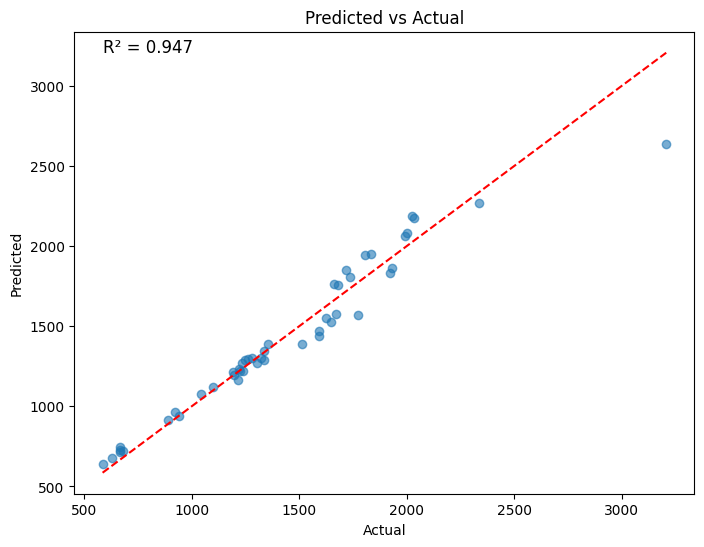

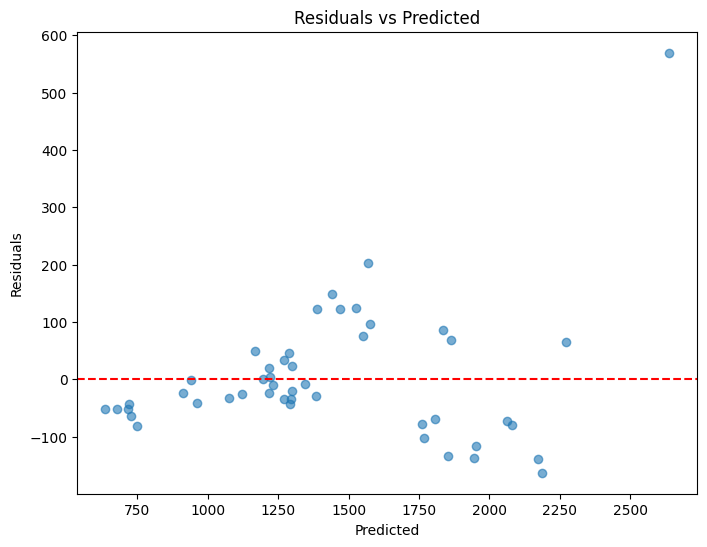

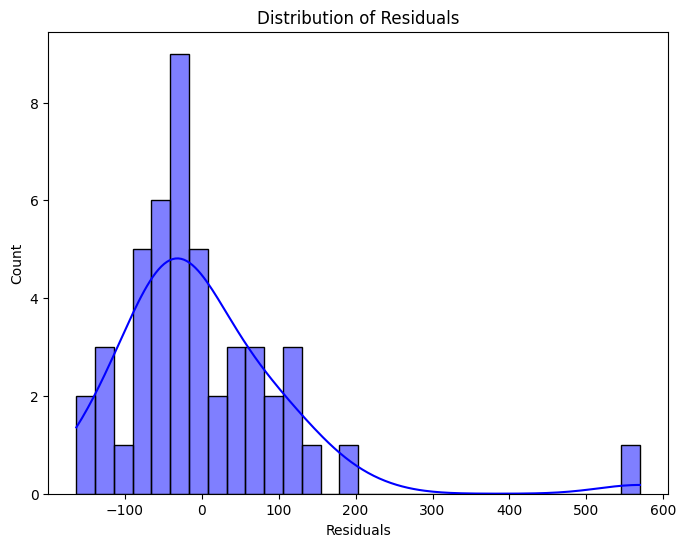

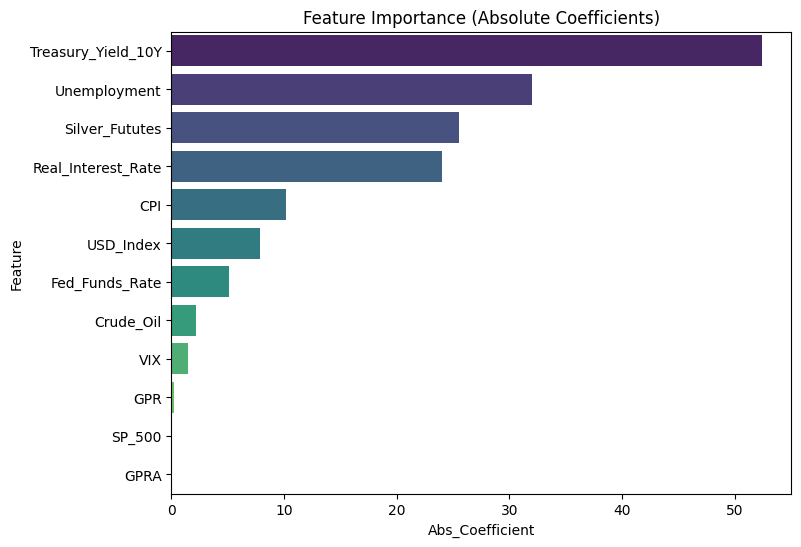

In [17]:
# =======================================
# Visualization: Evaluation Plots
# =======================================

# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.text(x=y_test.min(), y=y_test.max(),
         s=f"R² = {r2:.3f}",
         fontsize=12, color="black")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()


# Residuals vs Predicted
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


# Distribution of Residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.show()


# Feature Importance (Absolute Coefficients)
plt.figure(figsize=(8,6))
sns.barplot(data=coef_abs, x="Abs_Coefficient", y="Feature",hue="Feature" , palette="viridis", legend=False)
plt.title("Feature Importance (Absolute Coefficients)")
plt.show()

# ARIMA/SARIMA

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

In [19]:
# Train-Test Split (Time-series, No Shuffle)
gold = df["Gold_Spot"].resample("ME").last()
train_size = int(len(gold) * 0.8)
train, test = gold[:train_size], gold[train_size:]

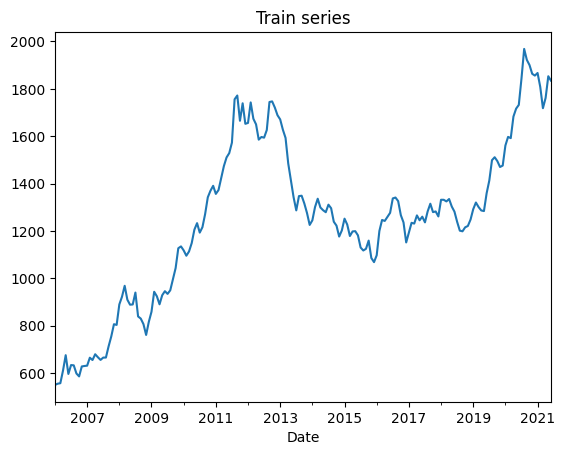

In [20]:
train.plot(title="Train series")
plt.show()

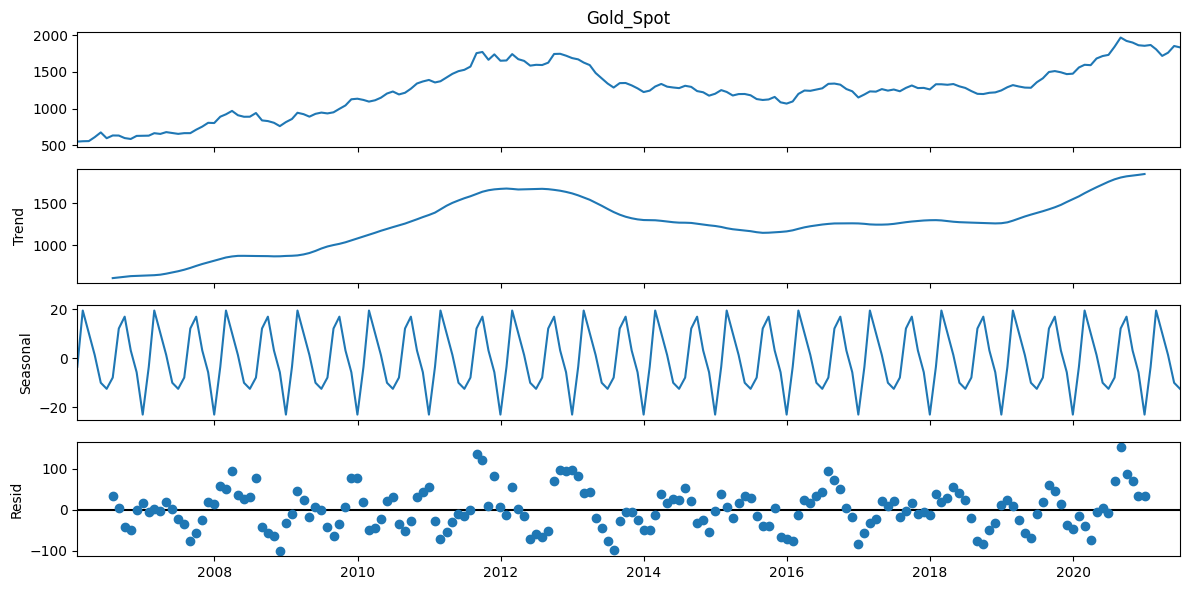

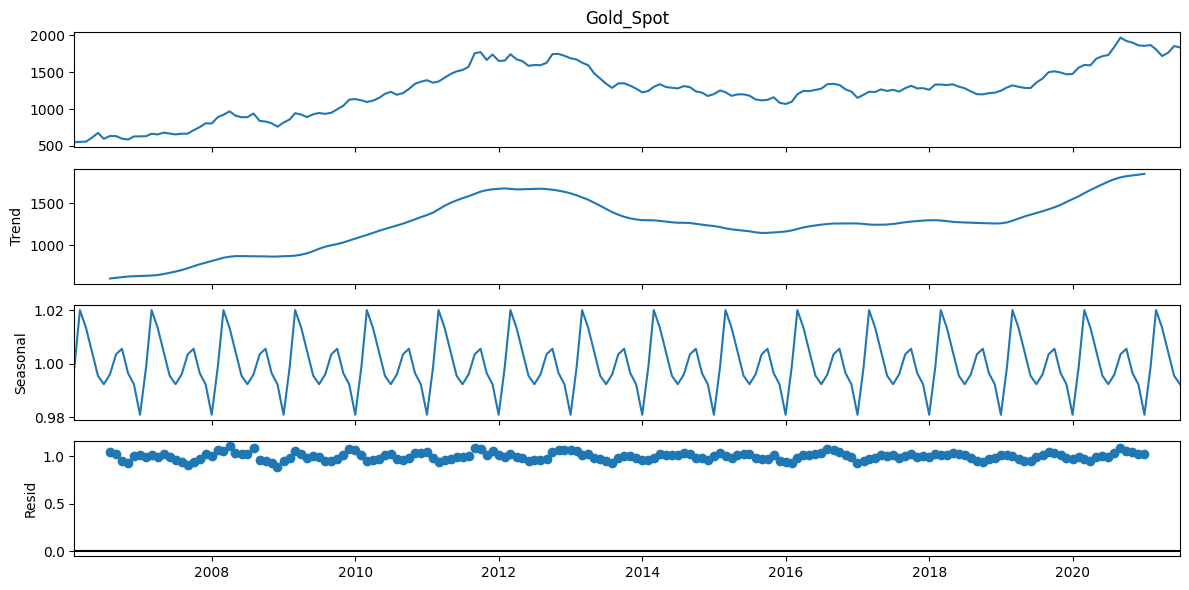

In [21]:
# --- Seasonal decomposition ---

decomp_add = seasonal_decompose(train, model="additive", period=12)
decomp_mul = seasonal_decompose(train, model="multiplicative", period=12)

plt.rc('figure', figsize=(12,6))

decomp_add.plot()
plt.show()

decomp_mul.plot()
plt.show()

In [22]:
from statsmodels.tsa.stattools import adfuller

# --- Check stationarity ---
result = adfuller(train)
# (adf_statistic, p_value, used_lag, n_obs, critical_values, icbest)
print("ADF Statistic:", result)

# if p value < 0.05 means the series is stationary
print("p-value:", result[1])

ADF Statistic: (-1.4297442052117602, 0.5679362553582067, 1, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, 1791.7431681599228)
p-value: 0.5679362553582067


**p value > 0.05, series not stationary -> need to differencing**

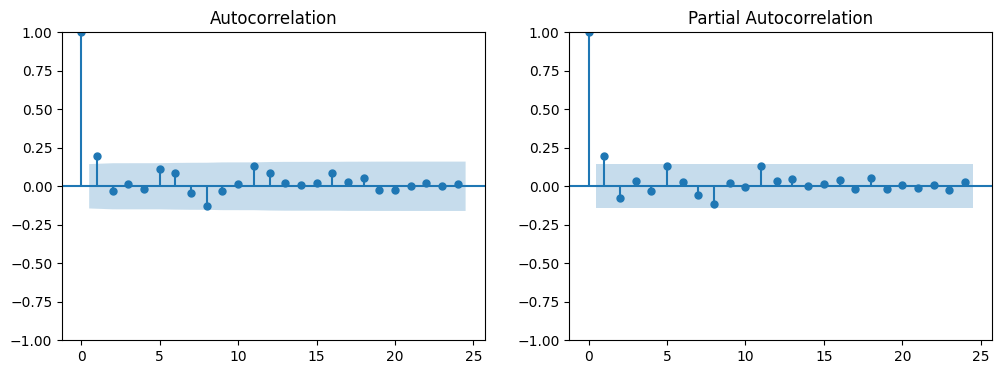

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# --- Explore ACF/PACF ---
train_diff = train.diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(train_diff, lags=24, ax=axes[0])
plot_pacf(train_diff, lags=24, ax=axes[1])
plt.show()


ACF spike at 1 -> q = 1,
PACF spike at 1 -> p = 1

In [24]:
# --- Manual ARIMA ---
arima_model = ARIMA(train, order=(1,1,1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))
arima_predicted = arima_result.predict()

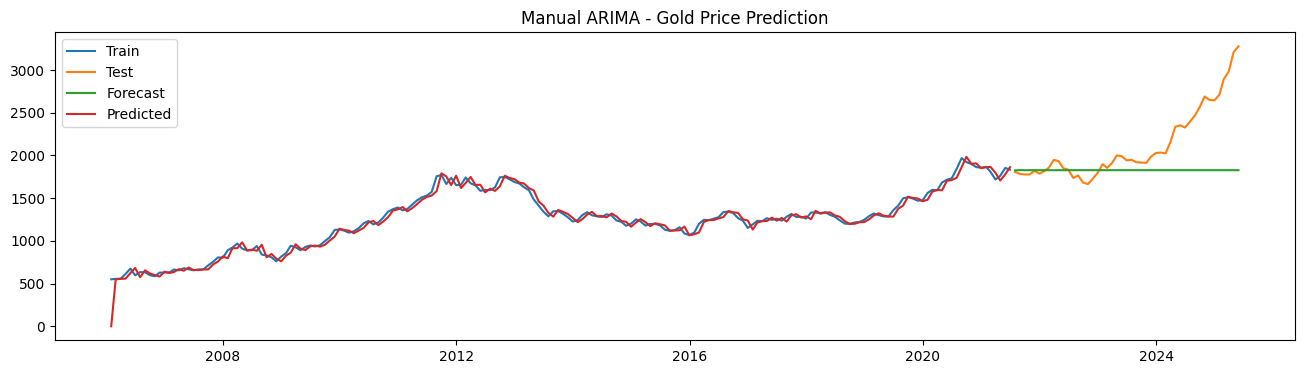

In [25]:
plt.figure(figsize=(16,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(arima_forecast.index, arima_forecast, label="Forecast")
plt.plot(arima_predicted, label="Predicted")
plt.title("Manual ARIMA - Gold Price Prediction")
plt.legend()
plt.show()

In [26]:
# --- Manual SARIMA ---
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=(len(test)))
sarima_predicted = sarima_result.predict()

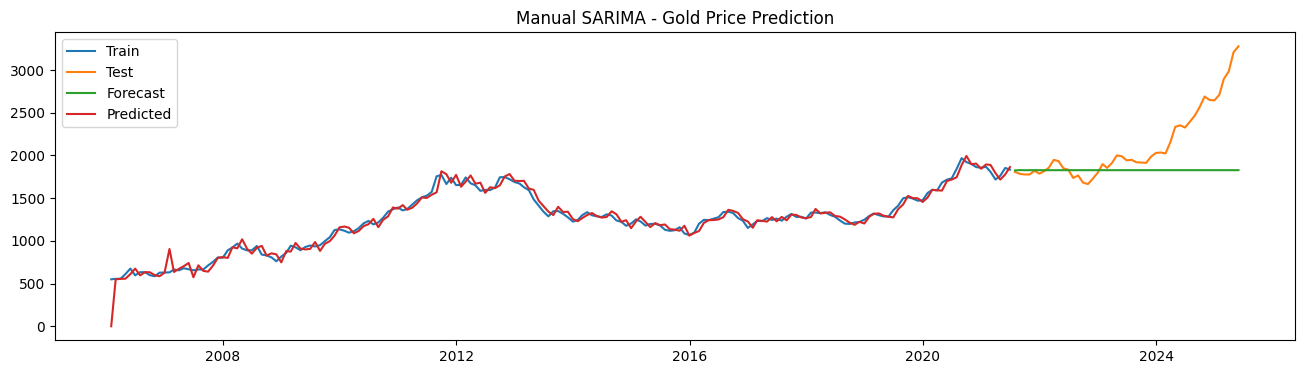

In [27]:
plt.figure(figsize=(16,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(sarima_forecast.index, arima_forecast, label="Forecast")
plt.plot(sarima_predicted, label="Predicted")
plt.title("Manual SARIMA - Gold Price Prediction")
plt.legend()
plt.show()

In [28]:
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true,y_pred)
    n, p = X_test.shape
    adj_r2 = round(1 - (1-r2) * (n-1) / (n-p-1), 3)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae =  mean_absolute_error(y_true, y_pred)
    print(f"{model_name} -> R2: {r2:.2f}, Adj R2: {adj_r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

evaluate_model(test, arima_forecast, "Manual ARIMA")

evaluate_model(test, sarima_forecast, "Manual SARIMA")

Manual ARIMA -> R2: -0.48, Adj R2: -1.007, MSE: 253129.23, RMSE: 503.12, MAE: 321.93
Manual SARIMA -> R2: 0.27, Adj R2: 0.009, MSE: 125009.10, RMSE: 353.57, MAE: 233.26


In [29]:
# --- Auto ARIMA(non-seasonal) ---
auto_arima_nonseasonal = pm.auto_arima(train, 
                           seasonal=False, 
                           test="adf", 
                           trace=True, 
                           error_action="ignore", 
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_arima_nonseasonal.summary())

arima_auto_forecast = auto_arima_nonseasonal.predict(n_periods=len(test))
evaluate_model(test, arima_auto_forecast, "Auto ARIMA(non-seasonal)")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1949.974, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1952.333, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1947.015, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1945.975, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1954.355, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1946.888, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1947.463, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1947.998, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1946.716, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.503 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -969.988
Date:                Wed, 29 Oct 2025   AIC      

In [30]:
# --- Auto ARIMA(seasonal) ---
auto_arima_seasonal = pm.auto_arima(
    train,
    seasonal = True,
    m=3,
    test="adf",
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(auto_arima_seasonal.summary())

sarima_auto_forecast = auto_arima_seasonal.predict(n_periods=len(test))
evaluate_model(test, sarima_auto_forecast, "Auto ARIMA (seasonal)")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=1950.829, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=1952.333, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=1948.909, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=1947.822, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=1954.355, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[3] intercept   : AIC=1945.975, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[3] intercept   : AIC=1947.802, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[3] intercept   : AIC=1948.825, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=1946.888, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[3] intercept   : AIC=1947.463, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[3] intercept   : AIC=1947.015, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[3] intercept   : AIC=1947.998, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[3]             : AIC=1946.716, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[3] intercept
Total fit time: 0.832 seconds
                      

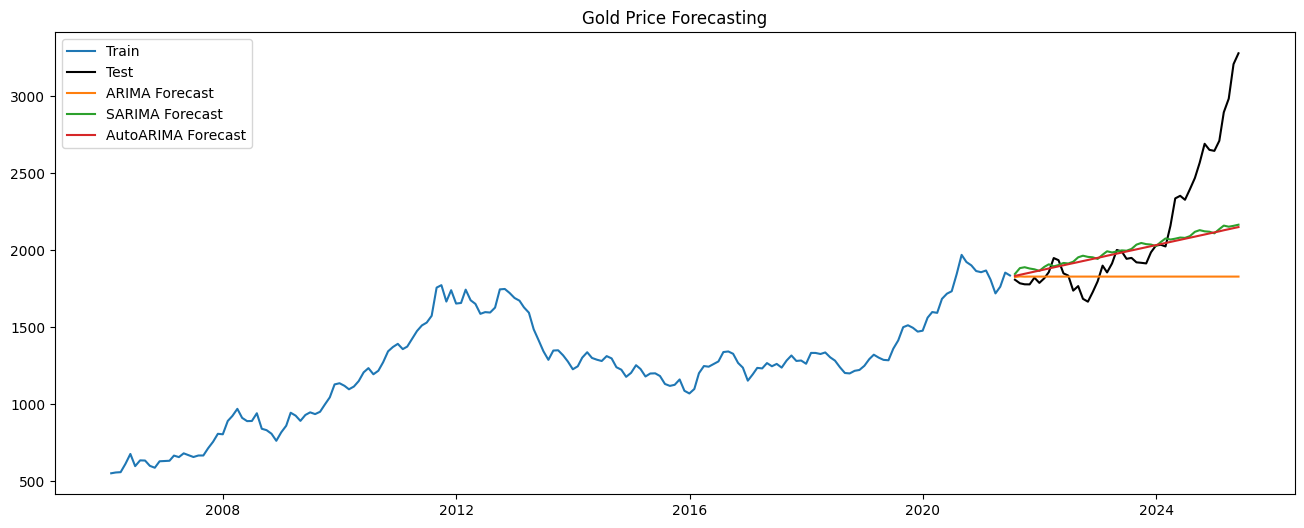

In [31]:
# --- Plot forecasts vs actual ---
plt.figure(figsize=(16,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="black")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast")
plt.plot(test.index, arima_auto_forecast, label="AutoARIMA Forecast")
plt.legend()
plt.title("Gold Price Forecasting")
plt.show()

**Comment** 

The baseline comparison shows that Multivariate Linear Regression outperforms ARIMA/SARIMA in predictive accuracy, explaining up to 95% of gold price variability with relatively low error metrics. While ARIMA/SARIMA effectively captures temporal patterns and ensures sound residual diagnostics, its univariate nature and weaker interpretability in economic terms limit its predictive power compared to models using multiple macroeconomic indicators. Overall, Linear Regression serves as the stronger baseline, whereas ARIMA/SARIMA functions as a useful benchmark for validating time-series dynamics. This contrast underscores the need to combine feature-rich machine learning methods with advanced deep learning architectures to achieve more reliable and comprehensive forecasting performance.

# Traditional Machine Learning Models

## 1. Support Vector Regression (SVR)

In [32]:
# Import library
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [33]:
X = df.drop(columns=["Gold_Spot"])
y = df["Gold_Spot"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()



In [34]:
param_grid = {
    "C": [1, 10, 100],
    "gamma": ["scale", 0.1, 0.01],
    "epsilon": [0.01, 0.1, 1]
}

grid = GridSearchCV(SVR(kernel="rbf"), param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X_train_scaled, y_train_scaled)

print("Best Params:", grid.best_params_)

Best Params: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}


In [35]:
# Train SVR model
svr_model = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=0.01)
svr_model.fit(X_train_scaled, y_train_scaled)

# Forecast
y_pred_scaled = svr_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

r2 = r2_score(y_test, y_pred)
n, p = X_test.shape
adj_r2 = round(1 - (1-r2) * (n-1) / (n-p-1), 3)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("\n=== SVR Results ===")
print(f"R2: {r2:.3f}, Adj R2: {adj_r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")


=== SVR Results ===
R2: 0.986, Adj R2: 0.981
MSE: 3592.15 | RMSE: 59.93 | MAE: 43.77


| Model               | R²    | Adjusted R² | MSE       | RMSE    | MAE    |
|---------------------|-------|-------------|-----------|---------|--------|
| Linear Regression   | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Ridge Regression    | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Manual SARIMA       | 0.27  | 0.009       | 125009.10 | 353.57  | 233.26 |
| SVR                 | 0.986 | 0.981       | 3592.15   | 59.93   | 43.77  |

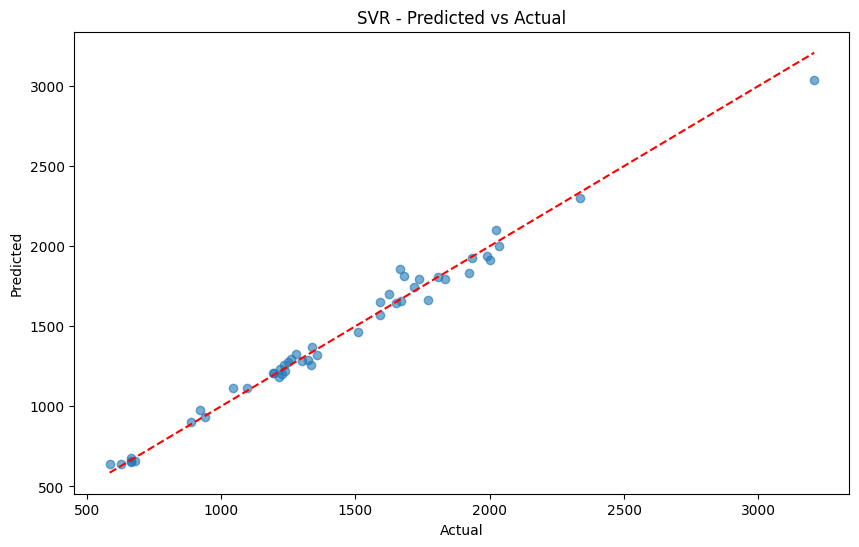

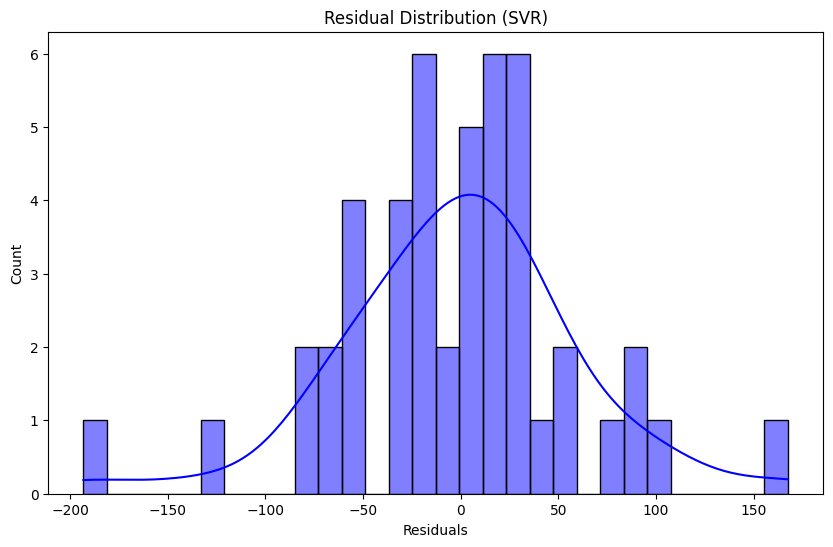

In [36]:
# Predicted vs Actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("SVR - Predicted vs Actual")
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.title("Residual Distribution (SVR)")
plt.xlabel("Residuals")
plt.show()


## 2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X = df.drop(columns=["Gold_Spot"])
y = df["Gold_Spot"]

X_train, X_test, y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [38]:
# GridSearch 

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

params_grid_rf = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}

grid = GridSearchCV(estimator=rf, 
                    param_grid=params_grid_rf, 
                    cv=5, 
                    scoring="r2", 
                    n_jobs=-1, 
                    verbose=2
                    )

# Run GridSearch
grid.fit(X_train, y_train)

# Best Model
best_rf = grid.best_estimator_

print("\n=== Best Parametors ===")
print("Best params:", grid.best_params_)


# --- Evaluate ---

r2 = r2_score(y_test, y_pred)
n, p = X_test.shape
adj_r2 = round(1 - (1-r2) * (n-1) / (n-p-1), 3)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Random Forest (GridSearchCV) Results ===")
print(f"R2: {r2:.3f} | Adj R2: {adj_r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

=== Best Parametors ===
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

=== Random Forest (GridSearchCV) Results ===
R2: 0.986 | Adj R2: 0.981
MSE: 3592.15 | RMSE: 59.93 | MAE: 43.77


cv = 5
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

=== Best Parametors ===
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

=== Random Forest (GridSearchCV) Results ===
R2: 0.986 | Adj R2: 0.981
MSE: 3592.15 | RMSE: 59.93 | MAE: 43.77

| Model               | R²    | Adjusted R² | MSE       | RMSE    | MAE    |
|---------------------|-------|-------------|-----------|---------|--------|
| Linear Regression   | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Ridge Regression    | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Manual SARIMA       | 0.27  | 0.009       | 125009.10 | 353.57  | 233.26 |
| SVR                 | 0.986 | 0.981       | 3592.15   | 59.93   | 43.77  |
| Random Forest       | 0.986 | 0.981       | 3592.15   | 59.93   | 43.77  |

In [39]:
# Feature Importance
feature_imp = pd.DataFrame({
    "Features": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop Features by Importance:")
print(feature_imp)


Top Features by Importance:
              Features  Importance
4                  CPI    0.233280
1               SP_500    0.212303
0       Silver_Fututes    0.183171
7   Real_Interest_Rate    0.093477
3            USD_Index    0.092086
5         Unemployment    0.047493
6   Treasury_Yield_10Y    0.046219
8       Fed_Funds_Rate    0.034167
10                 GPR    0.019004
11                GPRA    0.018914
9            Crude_Oil    0.011307
2                  VIX    0.008578


## 3. Gradient Boosting

In [40]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [41]:
# Base Model
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
    "gamma": [0, 1, 5]
}

# GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_xgb.best_estimator_
print("\n=== Best Parameters (XGBoost) ===")
print(grid_xgb.best_params_)

# Predict
y_pred = best_xgb.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
n, p = X_test.shape
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== XGBoost (GridSearchCV) Results ===")
print(f"R2: {r2:.3f} | Adj R2: {adj_r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

=== Best Parameters (XGBoost) ===
{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}

=== XGBoost (GridSearchCV) Results ===
R2: 0.973 | Adj R2: 0.964
MSE: 6833.86 | RMSE: 82.67 | MAE: 51.11


| Model               | R²    | Adjusted R² | MSE       | RMSE    | MAE    |
|---------------------|-------|-------------|-----------|---------|--------|
| Linear Regression   | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Ridge Regression    | 0.947 | 0.928       | 13427.07  | 115.88  | 77.06  |
| Manual SARIMA       | 0.27  | 0.009       | 125009.10 | 353.57  | 233.26 |
| SVR                 | 0.986 | 0.981       | 3592.15   | 59.93   | 43.77  |
| Random Forest       | 0.986 | 0.981       | 3592.15   | 59.93   | 43.77  |
| XGBoost             | 0.973 | 0.964       | 6833.86   | 82.67   | 51.11  |


# Deep Learning

In [3]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Dense, Dropout, BatchNormalization, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import random, os

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
def evaluate_regression(y_true, y_pred):
    """
    Evaluate regression model performance using common metrics.
    
    Parameters:
        y_true (array-like): True target values (ground truth).
        y_pred (array-like): Predicted target values from the model.
    
    Returns:
        dict: A dictionary containing regression metrics:
            - R2: Coefficient of determination (explained variance)
            - MSE: Mean Squared Error
            - RMSE: Root Mean Squared Error
            - MAE: Mean Absolute Error
    """
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred)
    }


def plot_history(history, title="Loss"):
    """
    Plot training and validation loss curves from Keras model history.
    
    Parameters:
        history (keras.callbacks.History): The History object returned by model.fit().
        title (str): Title of the plot (default is 'Loss').
    
    Description:
        - Plots 'loss' (training loss) and 'val_loss' (validation loss) vs. epochs.
        - Useful for detecting overfitting or underfitting.
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


def plot_scatter_pred_vs_actual(y_test, y_pred, title="Predicted vs Actual"):
    """
    Visualize model predictions compared to actual target values.
    
    Parameters:
        y_test (array-like): True target values.
        y_pred (array-like): Predicted target values from the model.
        title (str): Title of the plot (default is 'Predicted vs Actual').
    
    Description:
        - Creates a scatter plot comparing predicted vs. actual values.
        - The red dashed line represents the perfect prediction line (y = x).
        - The closer the points are to this line, the better the model fits.
    """
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--')  # Reference line y = x
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.show()

def plot_series_actual_vs_pred(y_test, y_pred, title='Actual vs Predicted', ylabel='Price'):
        """
        Plot actual vs predicted time series (e.g., gold or stock prices).

        Parameters:
            y_test (array-like): True target values.
            y_pred (array-like): Predicted target values.
            scaler (object, optional): Fitted scaler (e.g., StandardScaler or MinMaxScaler) used during preprocessing.
                                    If provided, both y_test and y_pred will be inverse-transformed for readability.
            title (str): Title of the plot.
            ylabel (str): Label for the Y-axis.

        Description:
            - Visualizes real vs predicted price trends over time.
            - Useful for evaluating how closely predictions follow the true market pattern.
        """
        y_test, y_pred = np.array(y_test).flatten(), np.array(y_pred).flatten()
        plt.figure(figsize=(10,5))
        plt.plot(y_test, color='blue', label='Actual Price')
        plt.plot(y_pred, color='red', label='Predicted Price', alpha=0.8)
        plt.title(title)
        plt.xlabel("Time (Test Set)")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

In [5]:
def create_sequences_univariate(data, window_size):
    """Create sequences for univariate time-series (Gold_Spot only)."""
    data = np.asarray(data).astype('float32').flatten()
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X).reshape(-1, window_size, 1), np.array(y)

def create_sequences_multivariate(X_data, y_data, window_size):
    """Create sequences for multivariate time-series (all features)."""
    X, y = [], []
    for i in range(len(X_data) - window_size):
        X.append(X_data[i:i+window_size])
        y.append(y_data[i+window_size])
    return np.array(X), np.array(y)


# def time_based_split_sequences(X, y, train_ratio=0.8):
#     split = int(len(X) * train_ratio)
#     return X[:split], X[split:], y[:split], y[split:]

In [ ]:
# ============================================================
# Prepare Multivariate Sequences for RNN/LSTM/GRU
# ============================================================

# Define window size
window = 12

# Extract features and target
X = df.drop(columns=["Gold_Spot"]).values
y = df["Gold_Spot"].values

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Create multivariate sequences
X_seq, y_seq = create_sequences_multivariate(X_scaled, y_scaled, window)

# Time-based split (80/20)
# X_train, X_test, y_train, y_test = time_based_split_sequences(X_seq, y_seq, train_ratio=0.8)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)

print(f"X_train shape: {X_train.shape}")  # (samples, window, n_features)
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")  # (samples,)
print(f"y_test shape: {y_test.shape}")

X_train shape: (176, 12, 12)
X_test shape: (45, 12, 12)
y_train shape: (176,)
y_test shape: (45,)


## MLP

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


=== MLP Results ===
R2: 0.960
MSE: 10123.75 | RMSE: 100.62 | MAE: 78.85


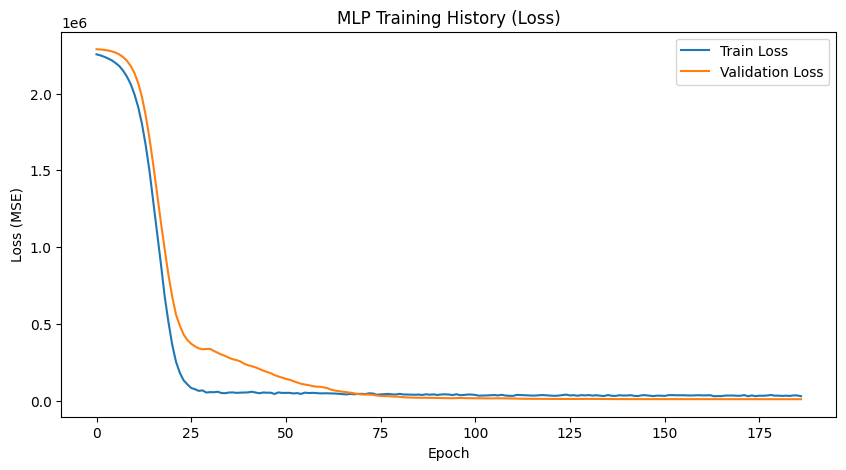

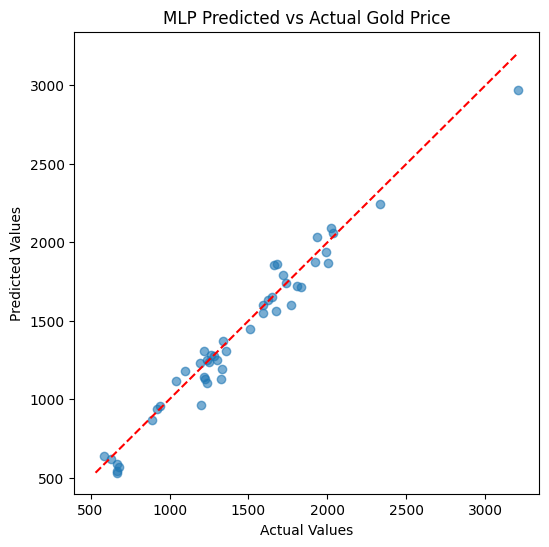

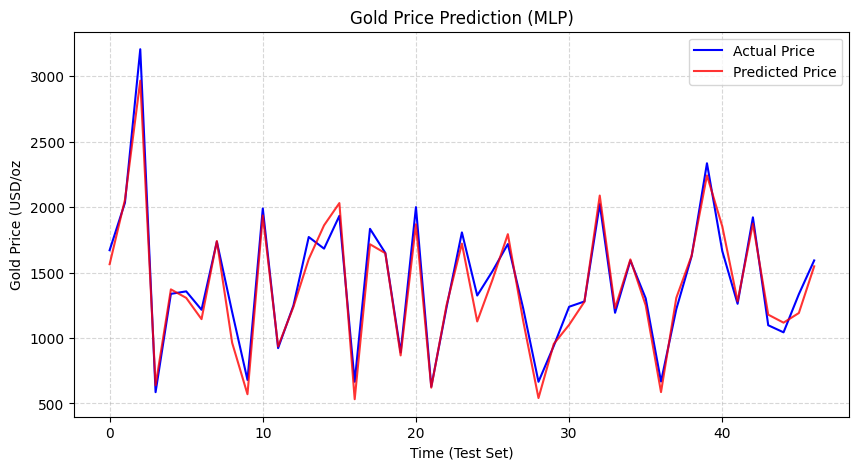

In [45]:
# MLP model
mlp = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])


callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_mlp.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=1)
]

# Train
history = mlp.fit(X_train_scaled, y_train,
                  validation_data=(X_test_scaled, y_test),
                  epochs=200,
                  batch_size=32,
                  callbacks=callbacks,
                  verbose=0)


# Predict
y_pred = mlp.predict(X_test_scaled, verbose=0)

metrics = evaluate_regression(y_test, y_pred)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== MLP Results ===")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

plot_history(history, "MLP Training History (Loss)")
plot_scatter_pred_vs_actual(y_test, y_pred, "MLP Predicted vs Actual Gold Price")
plot_series_actual_vs_pred(y_test, y_pred, title='Gold Price Prediction (MLP)', ylabel="Gold Price (USD/oz")

## RNN

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


=== RNN Results ===
R2: 0.600 
MSE: 69343.58 | RMSE: 263.33 | MAE: 184.26


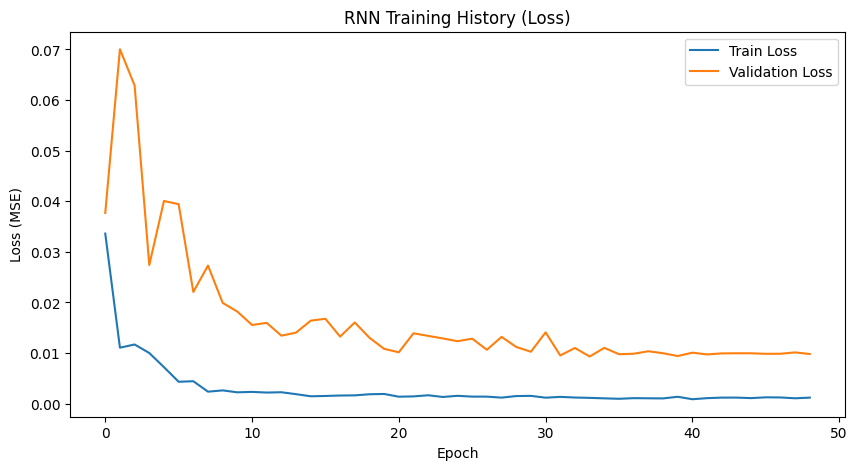

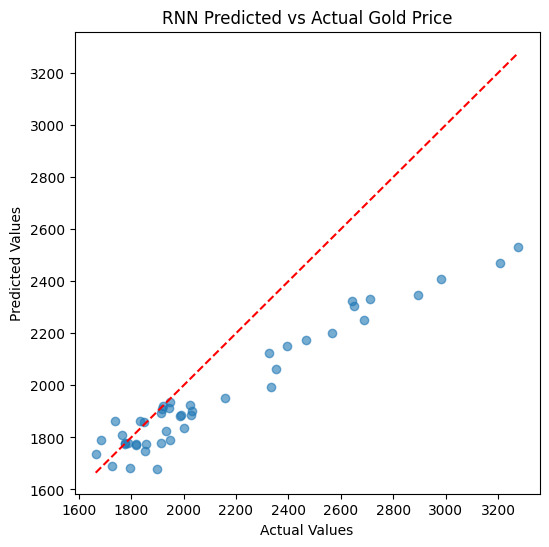

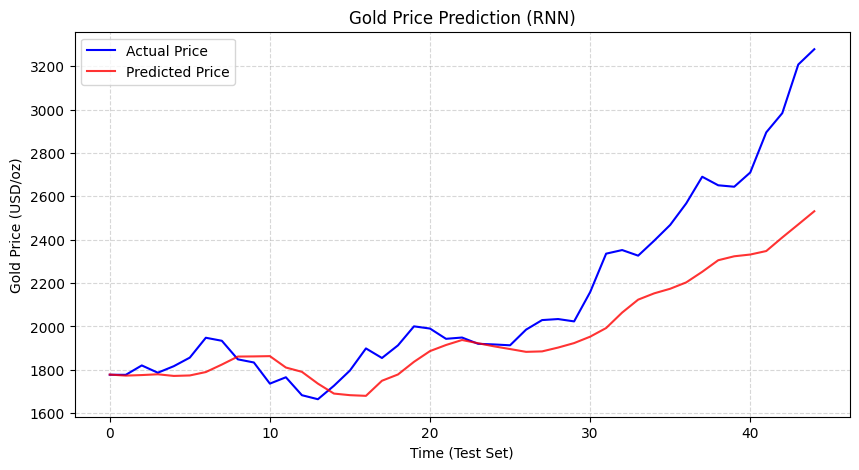

In [48]:
rnn = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_rnn.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=1)
]

# --- Train ---
history = rnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# --- Predict ---
y_pred = rnn.predict(X_test, verbose=0)

y_pred_inv = scaler.inverse_transform(y_pred).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- Evaluate ---
metrics = evaluate_regression(y_test_inv, y_pred_inv)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== RNN Results ===")
print(f"R2: {r2:.3f} ")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")


plot_history(history, "RNN Training History (Loss)")
plot_scatter_pred_vs_actual(y_test_inv, y_pred_inv, "RNN Predicted vs Actual Gold Price")
plot_series_actual_vs_pred(y_test_inv, y_pred_inv, title='Gold Price Prediction (RNN)', ylabel="Gold Price (USD/oz)")

## LSTM (Univariate)

0epoch [00:00, ?epoch/s]


=== LSTM Results ===
R2: 0.603
MSE: 68930.78 | RMSE: 262.55 | MAE: 193.85


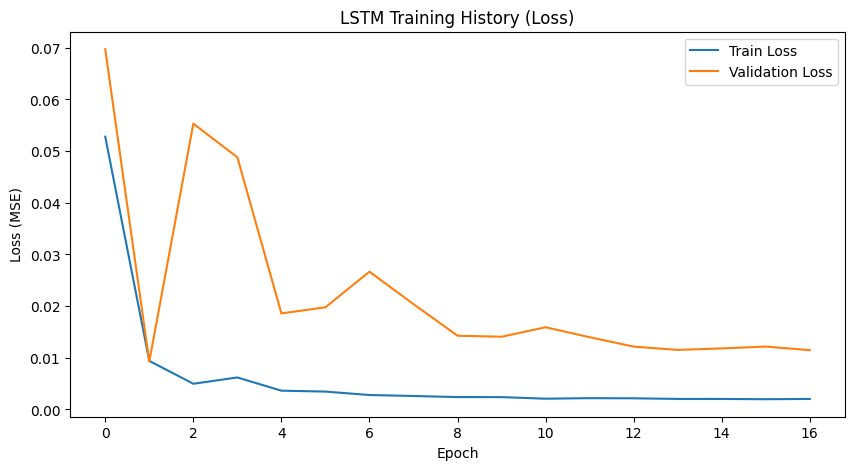

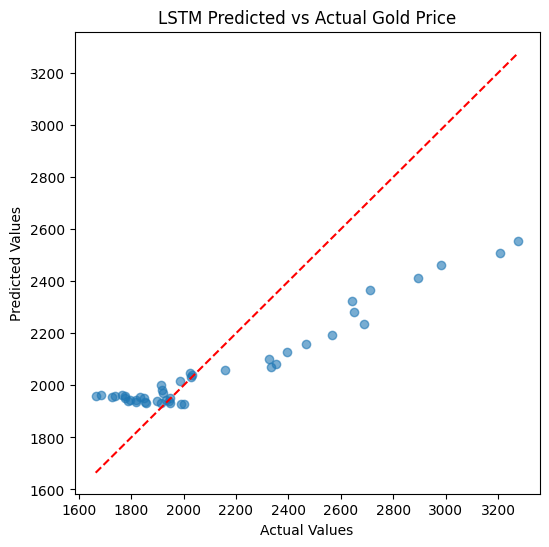

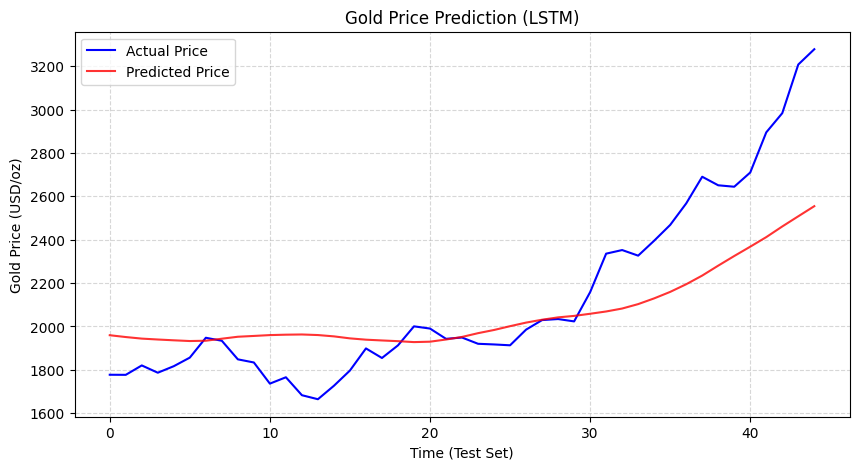

In [49]:
lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_lstm.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=0)
]

# Train
history = lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# --- Predict ---
y_pred = lstm.predict(X_test, verbose=0)

# --- Inverse transform ---
y_pred_inv = scaler.inverse_transform(y_pred).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- Evaluate ---
metrics = evaluate_regression(y_test_inv, y_pred_inv)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== LSTM Results ===")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# --- Plot ---
plot_history(history, "LSTM Training History (Loss)")
plot_scatter_pred_vs_actual(y_test_inv, y_pred_inv, "LSTM Predicted vs Actual Gold Price")
plot_series_actual_vs_pred(y_test_inv, y_pred_inv, title='Gold Price Prediction (LSTM)', ylabel="Gold Price (USD/oz)")

## GRU

0epoch [00:00, ?epoch/s]


=== GRU Results ===
R2: 0.843
MSE: 27202.49 | RMSE: 164.93 | MAE: 122.95


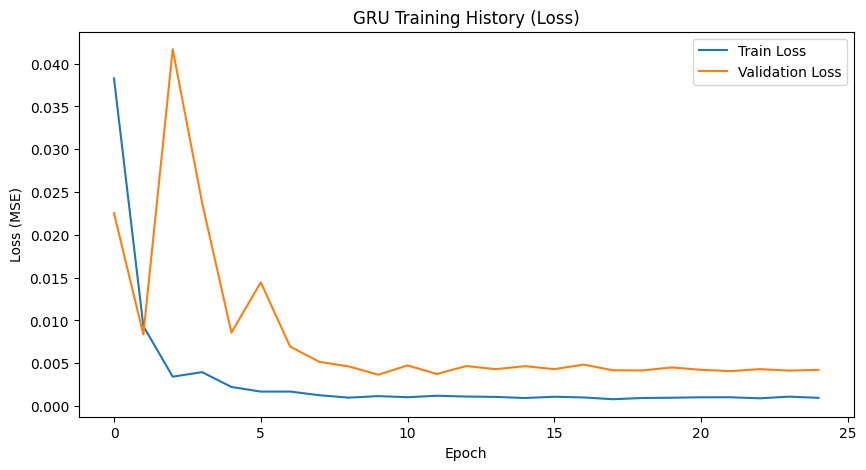

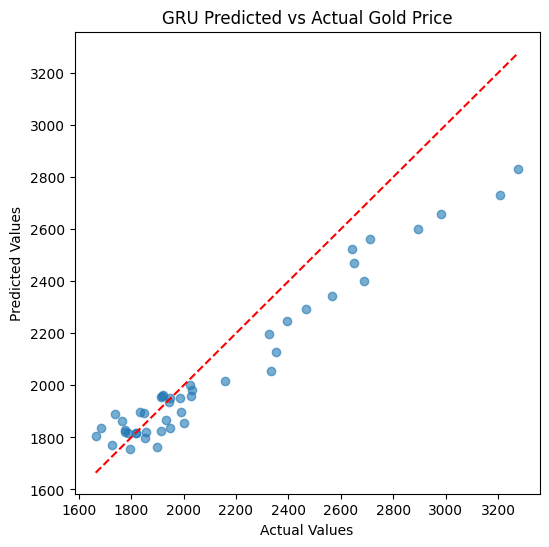

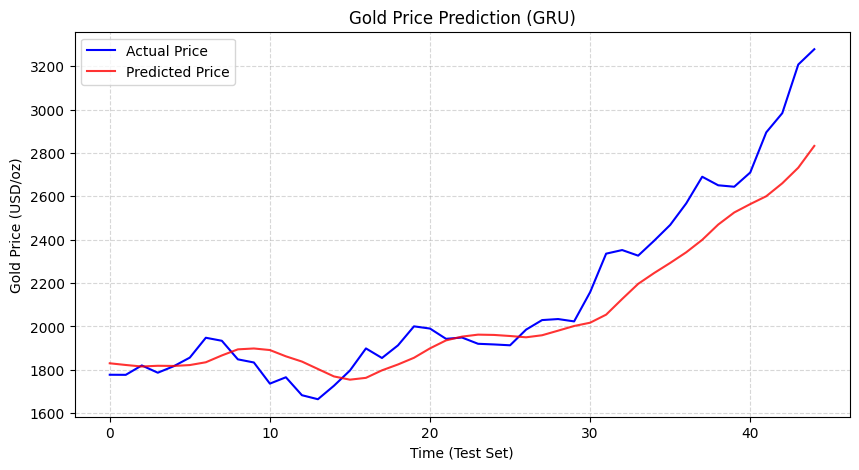

In [50]:
gru = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_gru.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=0)
]

# Train
history = gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# --- Predict ---
y_pred = gru.predict(X_test, verbose=0)

# --- Inverse transform ---
y_pred_inv = scaler.inverse_transform(y_pred).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- Evaluate ---
metrics = evaluate_regression(y_test_inv, y_pred_inv)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== GRU Results ===")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# --- Plot ---
plot_history(history, "GRU Training History (Loss)")
plot_scatter_pred_vs_actual(y_test_inv, y_pred_inv, "GRU Predicted vs Actual Gold Price")
plot_series_actual_vs_pred(y_test_inv, y_pred_inv, title='Gold Price Prediction (GRU)', ylabel="Gold Price (USD/oz)")

# Multivariate 

## RNN (Multivariate)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


=== RNN (Multivariate) Results ===
R2: 0.972
MSE: 5893.14 | RMSE: 76.77 | MAE: 58.99


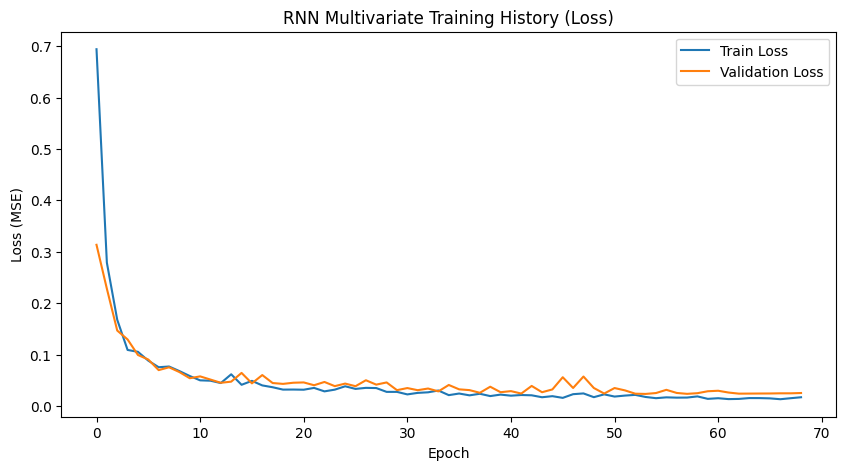

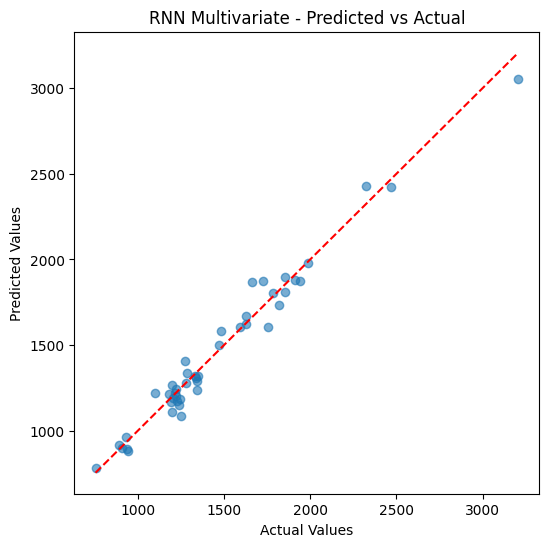

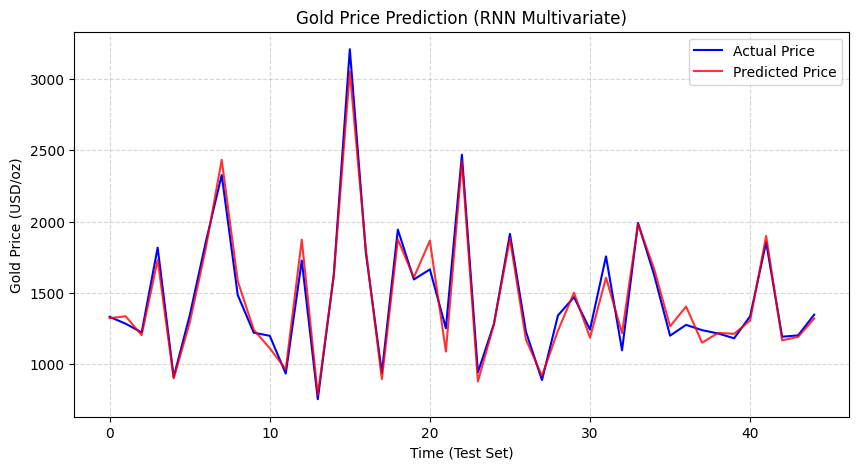

In [9]:
# ============================================================
# RNN (Multivariate)
# ============================================================

rnn = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # (window, n_features)
    SimpleRNN(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
], name="RNN_Multivariate")

rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_rnn_multivariate.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=1)
]

# Train
history = rnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# Predict
y_pred = rnn.predict(X_test, verbose=0)

# Inverse transform
y_pred_inv = scaler_y.inverse_transform(y_pred).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
metrics = evaluate_regression(y_test_inv, y_pred_inv)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== RNN (Multivariate) Results ===")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# Plot
plot_history(history, "RNN Multivariate Training History (Loss)")
plot_scatter_pred_vs_actual(y_test_inv, y_pred_inv, "RNN Multivariate - Predicted vs Actual")
plot_series_actual_vs_pred(y_test_inv, y_pred_inv, title='Gold Price Prediction (RNN Multivariate)', ylabel="Gold Price (USD/oz)")

## LSTM (Multivariate)

0epoch [00:00, ?epoch/s]


=== LSTM (Multivariate) Results ===
R2: 0.990
MSE: 2052.77 | RMSE: 45.31 | MAE: 37.84


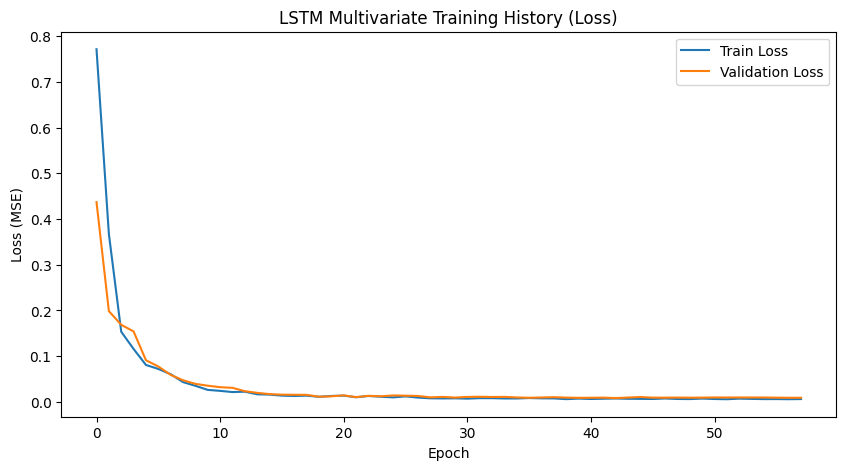

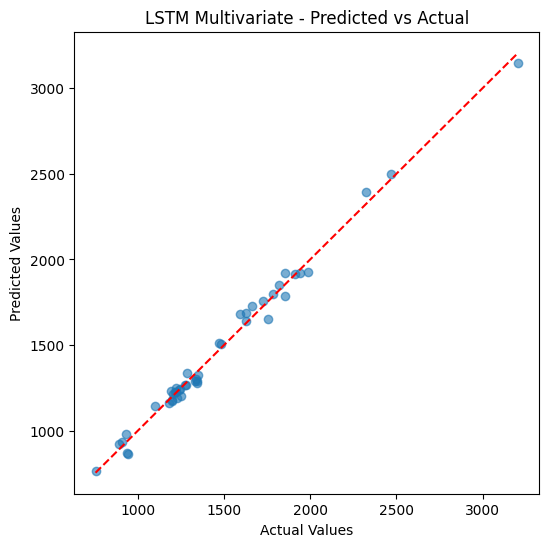

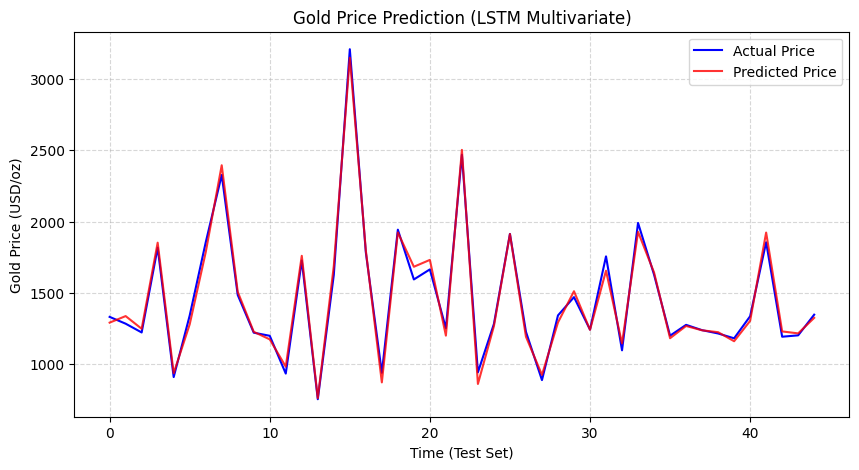

In [12]:
# ============================================================
# LSTM (Multivariate)
# ============================================================

lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
], name="LSTM_Multivariate")

lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_lstm_multivariate.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=0)
]

# Train
history = lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# Predict
y_pred = lstm.predict(X_test, verbose=0)

# Inverse transform
y_pred_inv = scaler_y.inverse_transform(y_pred).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
metrics = evaluate_regression(y_test_inv, y_pred_inv)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== LSTM (Multivariate) Results ===")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# Plot
plot_history(history, "LSTM Multivariate Training History (Loss)")
plot_scatter_pred_vs_actual(y_test_inv, y_pred_inv, "LSTM Multivariate - Predicted vs Actual")
plot_series_actual_vs_pred(y_test_inv, y_pred_inv, title='Gold Price Prediction (LSTM Multivariate)', ylabel="Gold Price (USD/oz)")

## GRU (Multivariate)

0epoch [00:00, ?epoch/s]


=== GRU (Multivariate) Results ===
R2: 0.990
MSE: 2108.99 | RMSE: 45.92 | MAE: 34.94


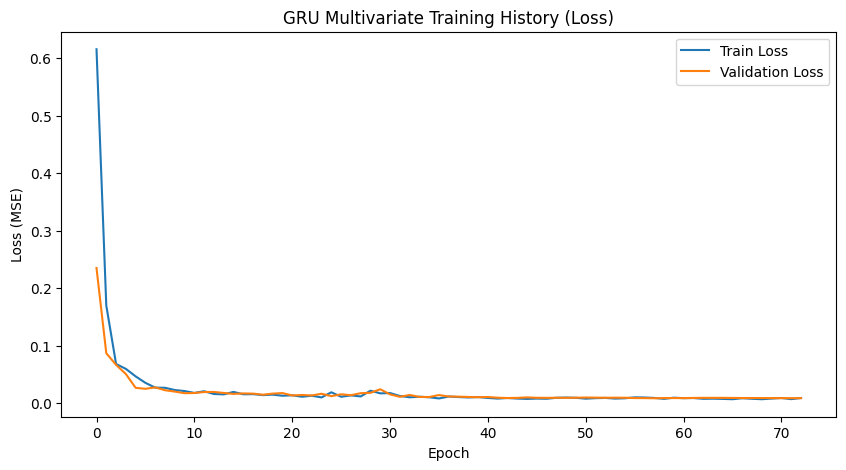

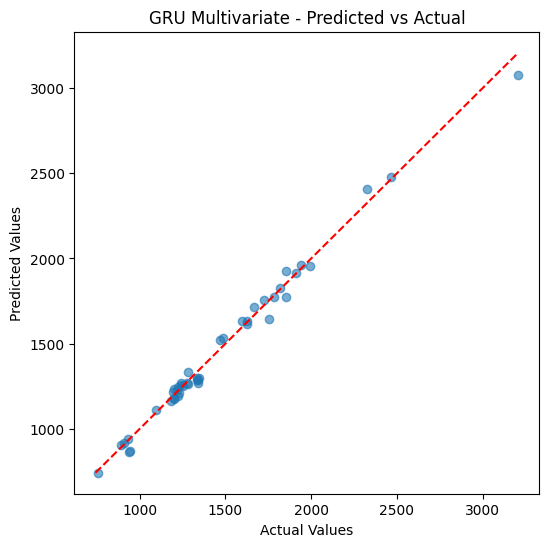

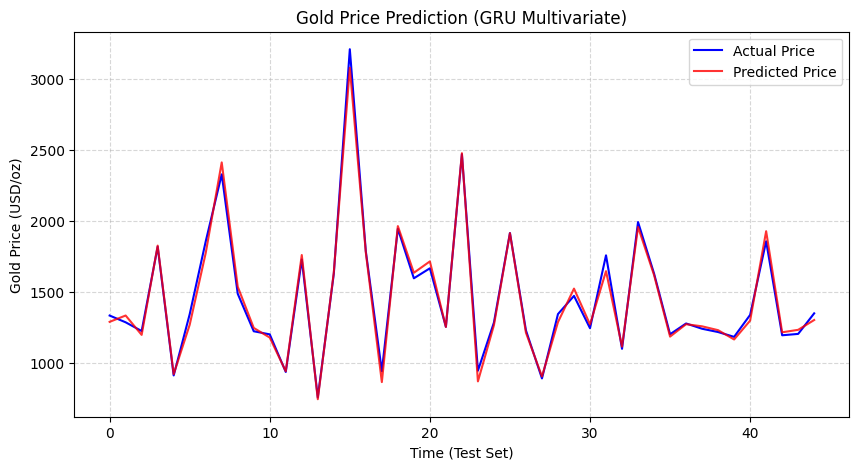

In [13]:
# ============================================================
# GRU (Multivariate)
# ============================================================

gru = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
], name="GRU_Multivariate")

gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint("../models/best_gru_multivariate.keras", monitor='val_loss', save_best_only=True, verbose=0),
    TqdmCallback(verbose=0)
]

# Train
history = gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# Predict
y_pred = gru.predict(X_test, verbose=0)

# Inverse transform
y_pred_inv = scaler_y.inverse_transform(y_pred).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
metrics = evaluate_regression(y_test_inv, y_pred_inv)
r2 = metrics["R2"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mae = metrics["MAE"]

print("\n=== GRU (Multivariate) Results ===")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# Plot
plot_history(history, "GRU Multivariate Training History (Loss)")
plot_scatter_pred_vs_actual(y_test_inv, y_pred_inv, "GRU Multivariate - Predicted vs Actual")
plot_series_actual_vs_pred(y_test_inv, y_pred_inv, title='Gold Price Prediction (GRU Multivariate)', ylabel="Gold Price (USD/oz)")